In [1]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#import warnings
#warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In this notebook, I plan to do the following:

1. Run Ridge/Lasso regression on engineered2 features
2. Try ExtraTrees regression
3. Try Gradient Boosting on polynomial features
4. Try regression on polynomial features
5. Try stacking or meta ensemble
6. Add features like median price based on the neighborhood and use it in stacking if useful
7. Analyze residuals for all the above cases!
8. Try other techniques like xgboost using linear and tree booster

## Load in the Data

Below data files are produced using the notebook below:
https://github.com/ptiwaree/Kaggle-HousePrices/blob/master/House%20Prices%20-%20Feature%20Engineering-2.ipynb

In [3]:
train = pd.read_csv('./../Data/train_engineered2.csv')
test = pd.read_csv('./../Data/test_engineered2.csv')
output = pd.read_csv('./../Data/log_SalePrice2.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1460, 299) (1459, 299) (1460, 1)


In [4]:
train.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

In [5]:
output.head(2)

log_SalePrice
0      12.247699
1      12.109016

## Data Analysis

In [10]:
train.columns.shape[0]

299

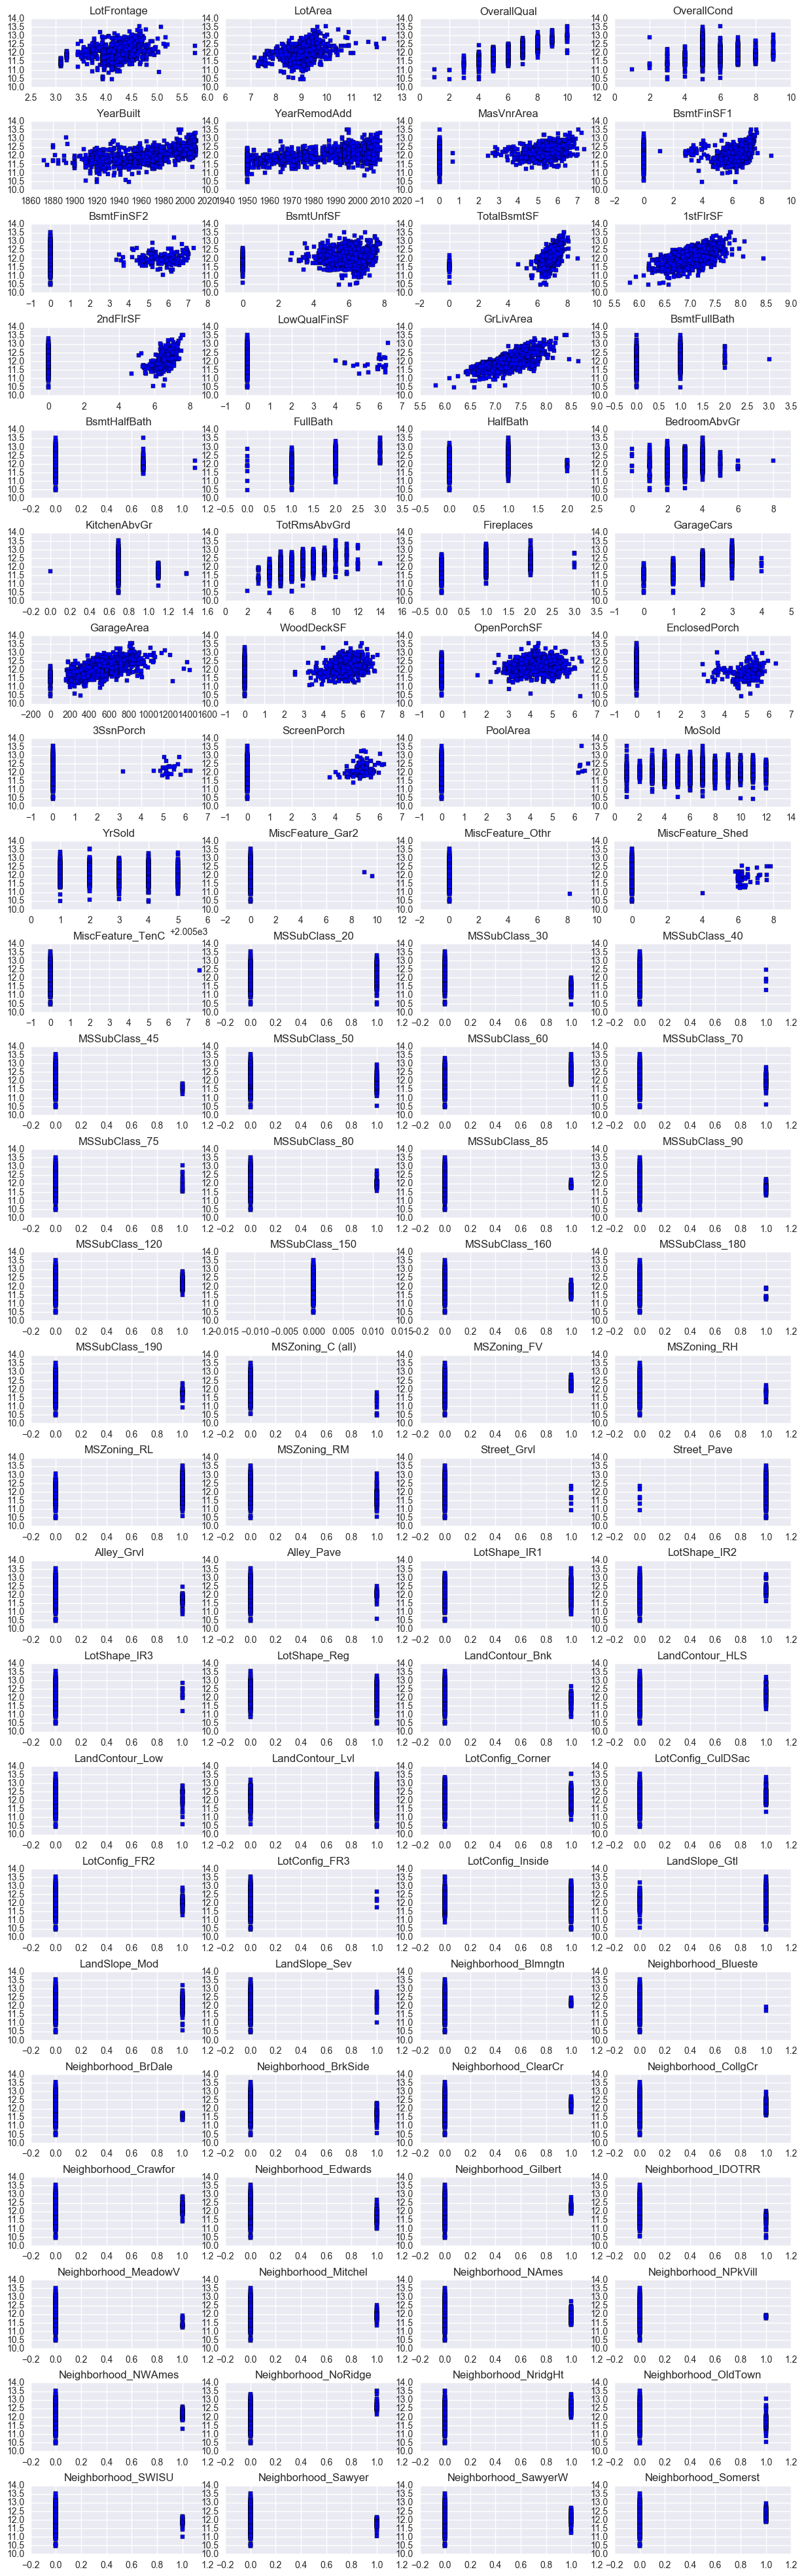

In [11]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i])

Looking at the above graph, we could potentially use polynomial features to improve results. Features like TotalBsmtSF could benefit from it. Other features that we could use polynomial transformation are:

MasVnrArea,
BsmtFinSF1,
BsmtFinSF2,
BsmtUnfSF,
TotalBsmtSF,
2ndFlrSF,
LowQualFinSF,
WoodDeckSF,
EnclosedPorch,
3SsnPorch,
ScreenPorch,
YrSold,
MiscFeature_Shed

In [12]:
train.shape

(1460, 299)

### Remove outliers

In [13]:
train.LotFrontage.sort_values(ascending=False).head(5)

934     5.749393
1298    5.749393
1127    5.209486
231     5.164786
197     5.164786
Name: LotFrontage, dtype: float64

In [14]:
index2include = train[train.LotFrontage < 5.209486].index
index2include

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1457)

In [15]:
train.loc[index2include, :].shape

(1457, 299)

In [16]:
train = train.loc[index2include, :] #remove LotFrontage outliers

In [17]:
output = output.loc[index2include, :] #remove LotFrontage outliers

In [18]:
train.shape, output.shape

((1457, 299), (1457, 1))

In [19]:
train.LotArea.sort_values(ascending=False).head(5)

313    12.279537
335    12.011644
249    11.976666
706    11.653991
451    11.167077
Name: LotArea, dtype: float64

In [20]:
index2include = train[train.LotArea < 11.167077].index

In [21]:
train = train.loc[index2include, :] #remove LotArea outliers
output = output.loc[index2include, :] #remove LotArea outliers
train.shape, output.shape

((1452, 299), (1452, 1))

In [22]:
train.TotalBsmtSF.sort_values(ascending=False).head(5)

332     8.073091
496     8.071219
523     8.051660
440     8.037543
1373    7.876259
Name: TotalBsmtSF, dtype: float64

In [23]:
index2include = train[train.TotalBsmtSF < 8.037543].index #remove TotalBsmtSF outliers

In [24]:
train = train.loc[index2include, :] #remove TotalBsmtSF outliers
output = output.loc[index2include, :] #remove TotalBsmtSF outliers
train.shape, output.shape

((1448, 299), (1448, 1))

In [25]:
train['1stFlrSF'].sort_values(ascending=False).head(5)

1024    7.972121
1373    7.876259
1044    7.833996
529     7.830426
691     7.801800
Name: 1stFlrSF, dtype: float64

In [26]:
train['GrLivArea'].sort_values(ascending=False).head(5)

1182    8.406708
691     8.370316
1169    8.196437
185     8.191186
304     8.158802
Name: GrLivArea, dtype: float64

In [27]:
index2include = train[train.GrLivArea < 8.191186].index #remove GrLivArea outliers

In [28]:
train = train.loc[index2include, :] #remove GrLivArea outliers
output = output.loc[index2include, :] #remove GrLivArea outliers
train.shape, output.shape

((1444, 299), (1444, 1))

In [29]:
train['GarageArea'].sort_values(ascending=False).head(5)

581     1390.0
1190    1356.0
1061    1248.0
825     1220.0
178     1166.0
Name: GarageArea, dtype: float64

In [30]:
index2include = train[train.GarageArea < 1166.0].index #remove GarageArea outliers

In [31]:
train = train.loc[index2include, :] #remove GarageArea outliers
output = output.loc[index2include, :] #remove GarageArea outliers
train.shape, output.shape

((1439, 299), (1439, 1))

### Lets look into output variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ee9fdd0>]], dtype=object)

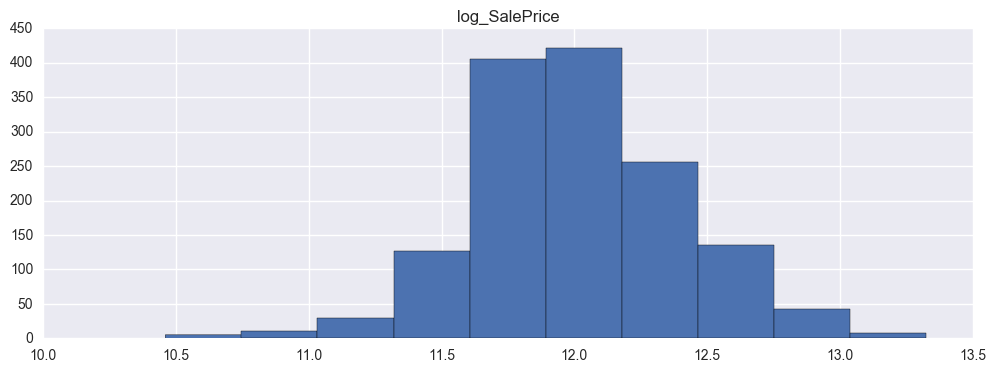

In [32]:
output.hist()

It looks a bit skewed so lets drop some extreme values.

In [33]:
output['log_SalePrice'].sort_values(ascending=True).head(20)

495     10.460271
916     10.471978
968     10.542733
533     10.579005
30      10.596660
710     10.859018
1337    10.868587
1325    10.915107
705     10.915107
812     10.933000
1380    10.976799
1100    11.002117
636     11.002117
410     11.002117
375     11.018646
462     11.041064
1432    11.074436
874     11.104972
398     11.112463
620     11.112463
Name: log_SalePrice, dtype: float64

In [34]:
index2include = output[output.log_SalePrice > 10.596660].index #remove output outliers

In [35]:
train = train.loc[index2include, :] #remove output outliers
output = output.loc[index2include, :] #remove output outliers
train.shape, output.shape

((1434, 299), (1434, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e5f73d0>]], dtype=object)

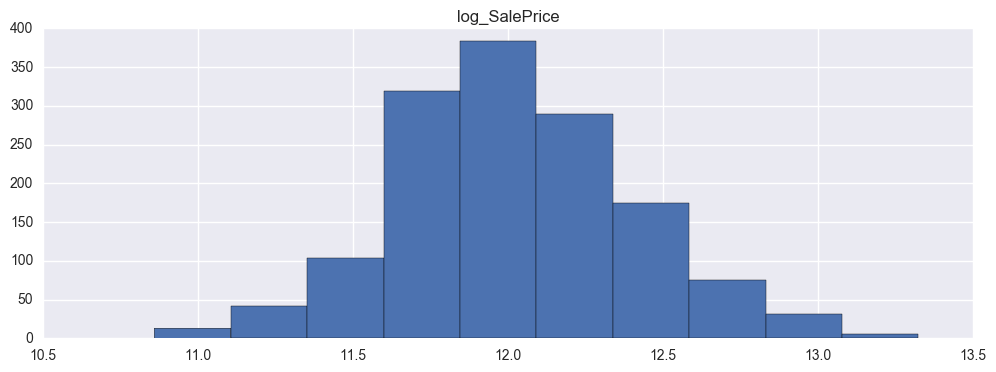

In [36]:
output.hist()

Output looks better! Now lets keep exploring the rest of the input variables!

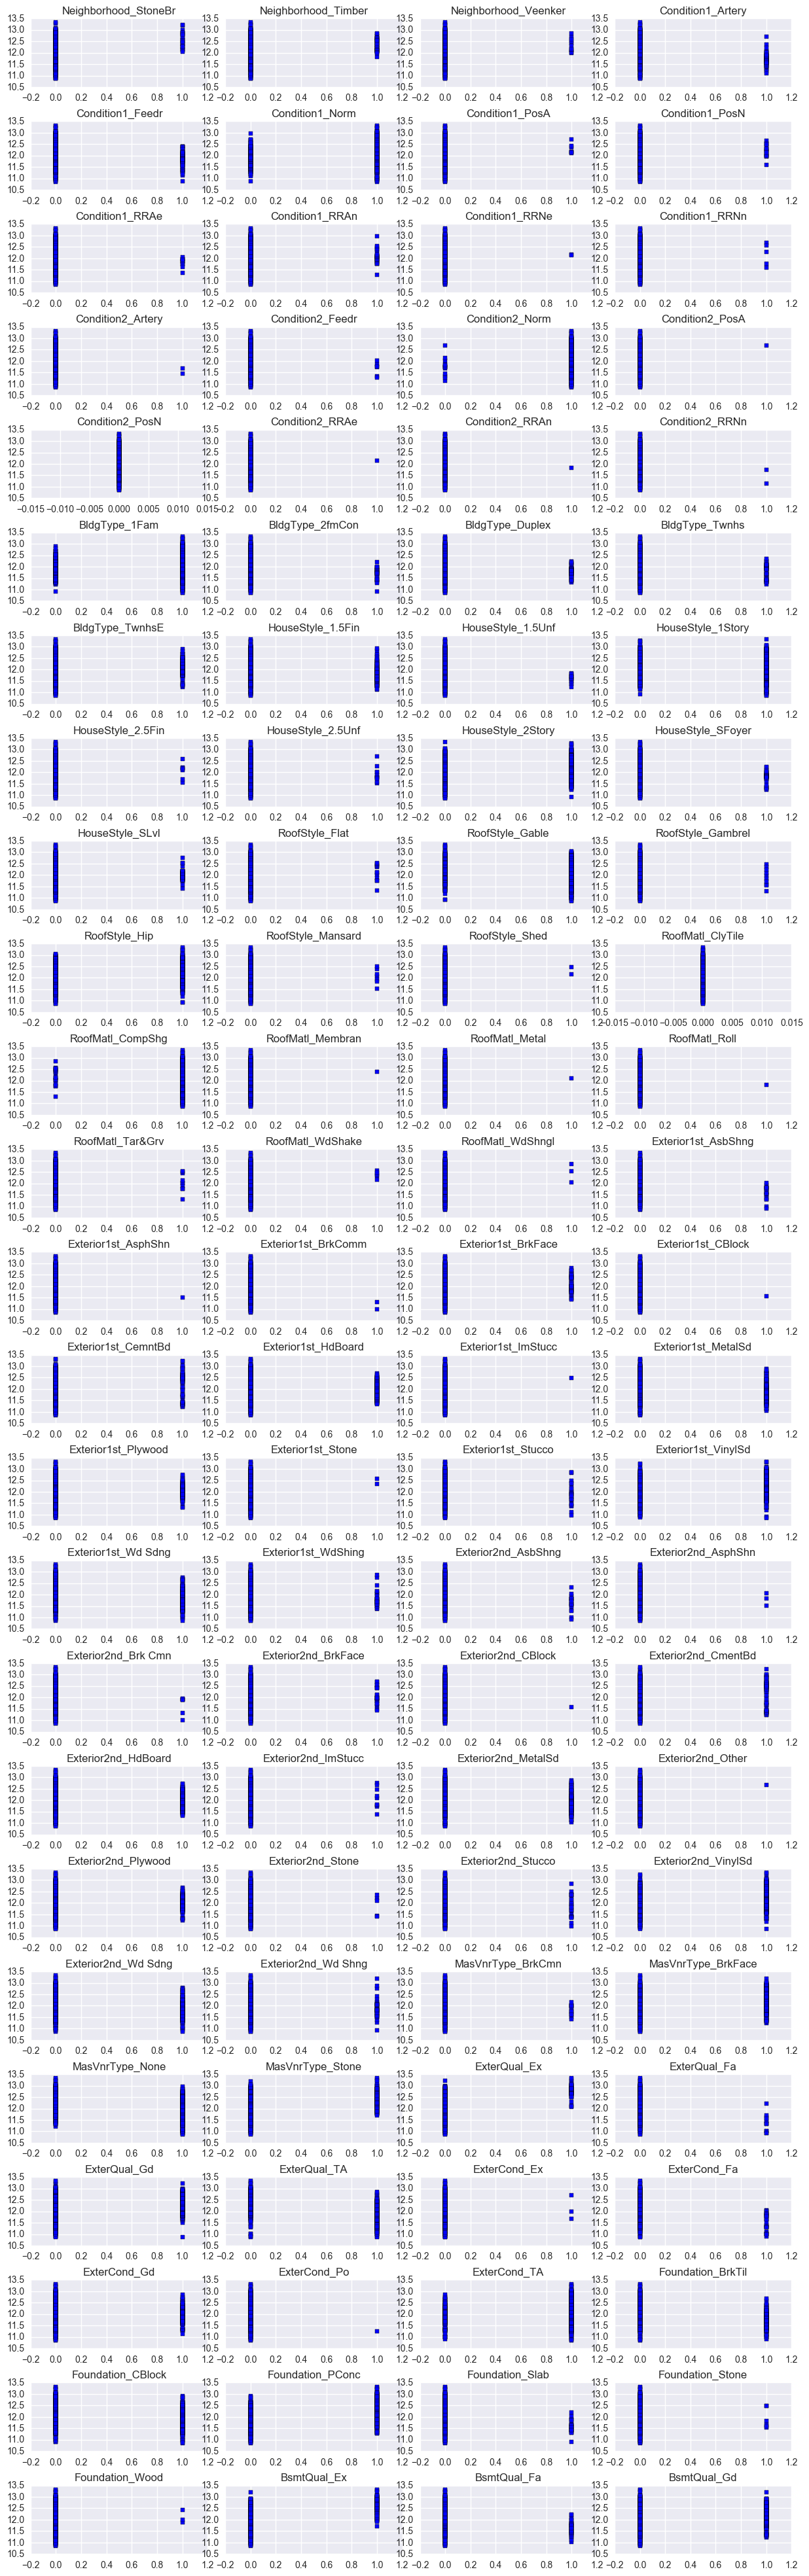

In [37]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i+100]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i+100])

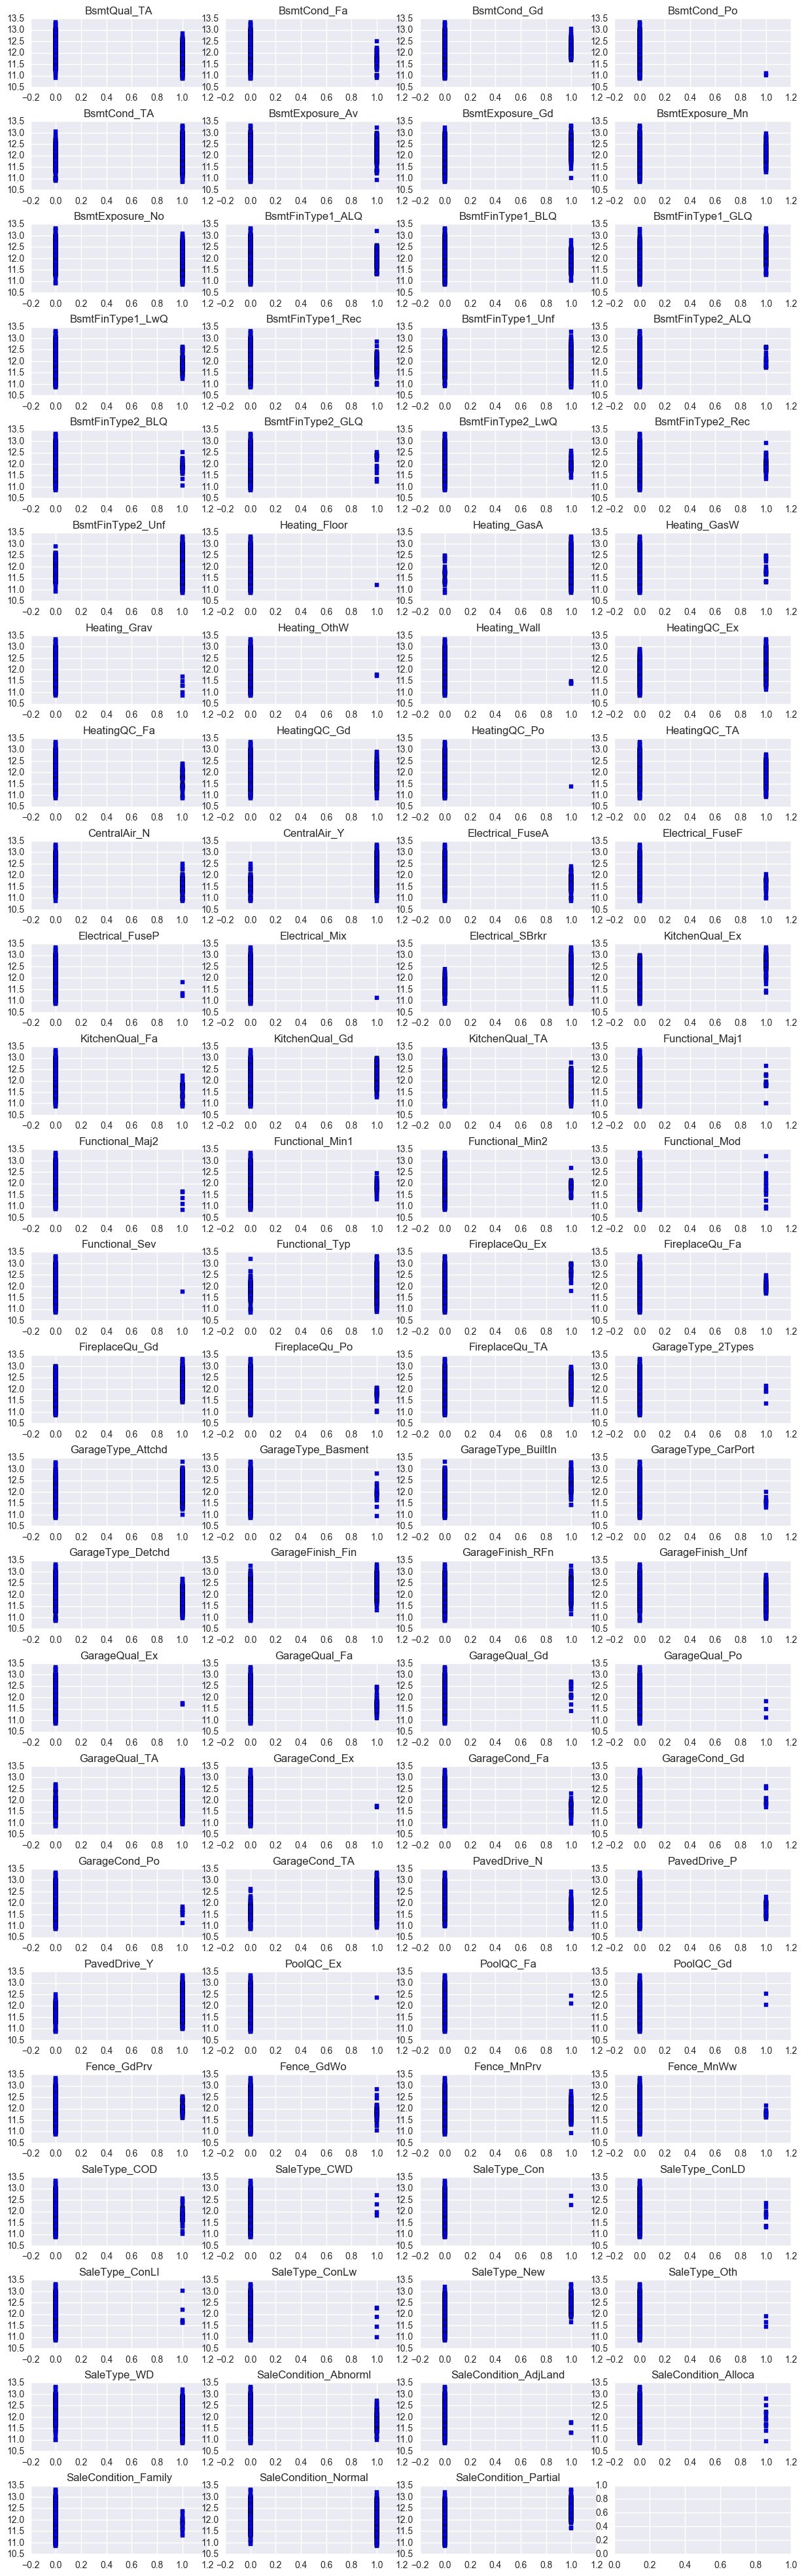

In [38]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(99):
    axs[i].scatter(train[train.columns[i+200]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i+200])

We can see that several variables have a trend line so they are likely to be good predictors!

## Modeling

### Lets start with Ridge Regression

In [39]:
def modelfit(model, dtrain, features, output, validation, validation_output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    validation_predictions = model.predict(validation[features])

    
    #Perform cross-validation:
    from sklearn.model_selection import cross_val_score
    from sklearn import metrics
    if performCV:
        cv_score = cross_val_score(model, dtrain[features], output, cv=cv_folds)
        cv_score_mse = cross_val_score(model, dtrain[features], output, cv=cv_folds, scoring='neg_mean_squared_error')
        
    
    #Print model report:
    print "\nModel Report"
    print "Training R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "Training RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))    
    print "Validation R-Square: %.3f" % metrics.r2_score(validation_output, validation_predictions)
    print "Validation RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(validation_output, validation_predictions))
    print('Variance score: %.2f' % model.score(validation, validation_output))
    print('Optimal Alpha: %.4f') %model.alpha_ 
    
    if performCV:
        print"Training cv_score (R^2 and MSE):  "
        print(cv_score)
        print(cv_score_mse)
        print "CV Score (R^2) : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        print "CV Score (MSE) : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score_mse),np.std(cv_score_mse),np.min(cv_score_mse),np.max(cv_score_mse))

    if printFeatureImportance:
        df = {'features': features.values, 'Coefficients': model.coef_[0]}
        coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
        plt.figure()
        coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
        plt.ylabel('Feature Coefs')
        plt.figure()
        coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
        plt.ylabel('Feature Coefs')

In [40]:
from sklearn import linear_model

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=27)

In [42]:
features = X_train.columns

In [43]:
alpha = 10**np.random.uniform(-1,1, size=100)
print alpha

[ 0.88567803  0.65276736  0.7833646   2.3795578   3.17890154  2.71028866
  0.57428628  6.55987206  1.04641938  3.52991407  1.85320306  0.11533307
  0.68878327  3.06605079  0.35585001  2.86781882  0.13817208  0.41115385
  3.06534636  0.28758324  0.21015357  0.4642682   0.49107036  6.15647873
  7.16695868  2.34013317  0.60511368  2.69189003  0.15123643  2.07642795
  0.79278562  3.3613865   4.16010161  2.22936965  2.03684347  2.29712142
  5.124452    1.25301083  0.20256983  0.63231048  8.16737268  3.44981862
  0.11745255  7.57696778  0.45156727  2.1128615   1.51370978  0.72636315
  9.04507657  6.5668431   1.04935422  1.5835257   2.01382849  0.19244504
  2.41015206  5.10014026  0.23416504  0.76809805  0.93881892  1.09695617
  0.3880206   0.28453937  0.76443466  0.1224532   0.22851435  1.7164201
  0.70398988  0.14165048  0.29607215  0.31985298  0.11914757  0.15478624
  0.80336532  0.27107724  0.20103195  1.41983593  1.09030627  5.53139857
  5.08425101  0.95715237  1.57043299  2.48166944  0.

In [44]:
ridge = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)


Model Report
Training R-Square: 0.945
Training RMSE : 0.089
Validation R-Square: 0.915
Validation RMSE : 0.110
Variance score: 0.91
Optimal Alpha: 9.0451
Training cv_score (R^2 and MSE):  
[ 0.90287359  0.92804912  0.91827212  0.9311909   0.91160728]
[-0.01151044 -0.00991713 -0.01268172 -0.01135304 -0.0127763 ]
CV Score (R^2) : Mean: 0.9183986 | Std: 0.01043014 | Min: 0.9028736 | Max: 0.9311909
CV Score (MSE) : Mean: -0.01164773 | Std: 0.001043404 | Min: -0.0127763 | Max: -0.009917133


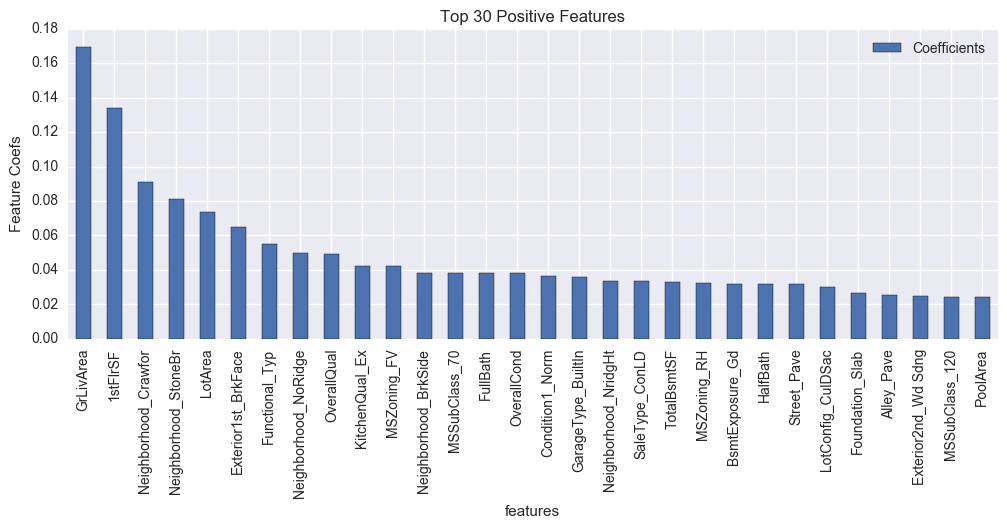

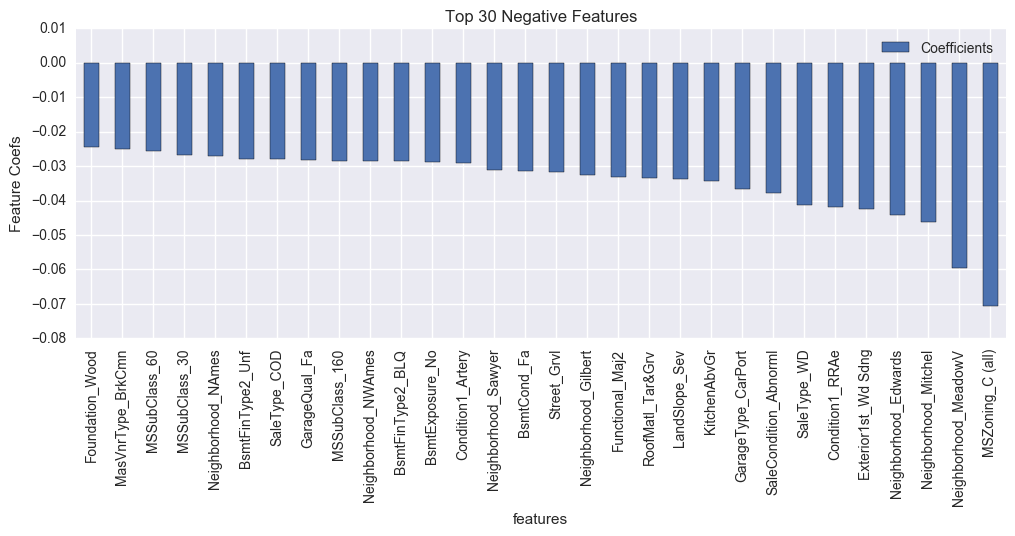

In [45]:
modelfit(ridge, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=True)

In [46]:
# The coefficients
df = {'features': features, 'Coefficients': ridge.coef_[0]}
ridge_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
ridge_coefficients

Coefficients               features
14       0.169357              GrLivArea
11       0.133831               1stFlrSF
84       0.091085   Neighborhood_Crawfor
100      0.081365   Neighborhood_StoneBr
1        0.073804                LotArea
150      0.064874    Exterior1st_BrkFace
249      0.054912         Functional_Typ
93       0.050018   Neighborhood_NoRidge
2        0.049415            OverallQual
239      0.042334         KitchenQual_Ex
54       0.042313            MSZoning_FV
81       0.038456   Neighborhood_BrkSide
43       0.038255          MSSubClass_70
17       0.038180               FullBath
3        0.038016            OverallCond
105      0.036442        Condition1_Norm
258      0.035745     GarageType_BuiltIn
94       0.033514   Neighborhood_NridgHt
287      0.033332         SaleType_ConLD
10       0.032729            TotalBsmtSF
55       0.032399            MSZoning_RH
206      0.032050        BsmtExposure_Gd
18       0.031853               HalfBath
59       0.031682            Street_Pave
71       0.030386      LotConfig_CulDSac
194      0.026735        Foundation_Slab
61       0.025310             Alley_Pave
176      0.024728    Exterior2nd_Wd Sdng
48       0.024470         MSSubClass_120
30       0.024307               PoolArea
..            ...                    ...
196     -0.024517        Foundation_Wood
178     -0.025135      MasVnrType_BrkCmn
42      -0.025717          MSSubClass_60
38      -0.026686          MSSubClass_30
90      -0.027132     Neighborhood_NAmes
220     -0.027845       BsmtFinType2_Unf
284     -0.028032           SaleType_COD
265     -0.028160          GarageQual_Fa
50      -0.028442         MSSubClass_160
92      -0.028451    Neighborhood_NWAmes
216     -0.028612       BsmtFinType2_BLQ
208     -0.028935        BsmtExposure_No
103     -0.028966      Condition1_Artery
97      -0.031056    Neighborhood_Sawyer
201     -0.031528            BsmtCond_Fa
58      -0.031682            Street_Grvl
86      -0.032583   Neighborhood_Gilbert
244     -0.033212        Functional_Maj2
144     -0.033472       RoofMatl_Tar&Grv
77      -0.033619          LandSlope_Sev
20      -0.034330           KitchenAbvGr
259     -0.036597     GarageType_CarPort
293     -0.037841  SaleCondition_Abnorml
292     -0.041273            SaleType_WD
108     -0.041895        Condition1_RRAe
160     -0.042415    Exterior1st_Wd Sdng
85      -0.044168   Neighborhood_Edwards
89      -0.046139   Neighborhood_Mitchel
88      -0.059447   Neighborhood_MeadowV
53      -0.070566       MSZoning_C (all)

[299 rows x 2 columns]

In [47]:
ridge_train_predictions = np.expm1(ridge.predict(train[features]))
ridge_test_predictions = np.expm1(ridge.predict(test[features]))

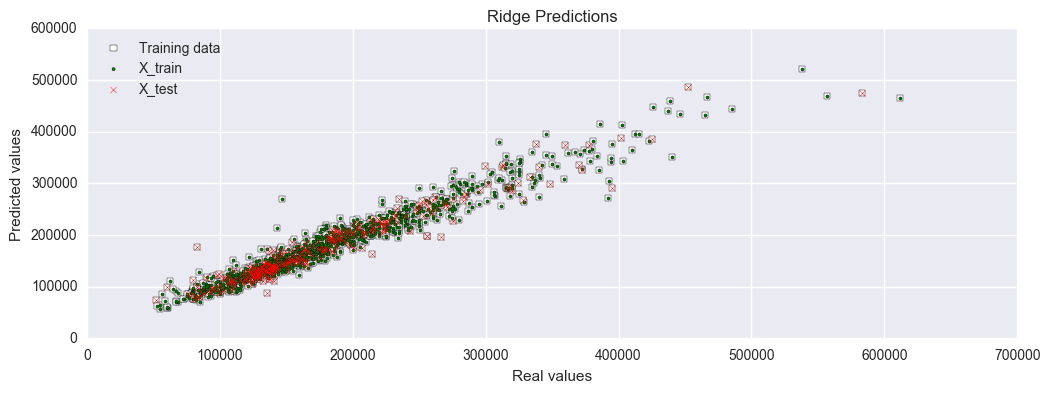

In [48]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(output.values), ridge_train_predictions, c = "white", marker = "s", label = "Training data")
plt.scatter(np.expm1(y_train.values), np.expm1(ridge.predict(X_train[features])), c = "green", marker = ".", label = "X_train")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[features])), c = "red", marker = "x", label = "X_test")

plt.title("Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

### Lets try Lasso

In [49]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)
alpha

array([  9.00534860e-02,   7.60146914e-04,   5.11923101e+00,
         3.63067492e-05,   2.18566500e-06,   4.14372376e-06,
         8.76450414e-05,   4.81927978e-04,   6.38497718e+00,
         1.15151096e+00,   7.06468125e+00,   7.37254520e+00,
         2.51012966e+00,   9.95301999e-03,   2.55785211e-04,
         8.33395978e-04,   1.04462628e-06,   1.17752633e-03,
         6.02806807e-04,   4.87854190e-05,   9.85783851e-05,
         4.84552017e-05,   3.79165967e-05,   8.02756864e-04,
         2.97517114e-04,   1.14569397e+00,   2.15086872e-01,
         1.51582654e-06,   3.03008728e-05,   1.21960250e-04,
         3.17956286e-04,   5.47234826e-04,   4.08363968e+00,
         7.07043032e-03,   1.74805925e-04,   2.70797325e-02,
         9.83338660e-06,   1.00985284e+00,   2.16750739e+00,
         1.08401327e-04,   3.94805435e-01,   2.61485588e-02,
         4.50242340e-03,   1.92905714e-03,   2.81384054e-04,
         4.03318705e-05,   2.92611399e-05,   1.97226855e-01,
         5.47830246e+00,

In [50]:
lasso = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [51]:
modelfit(lasso, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Model Report
Training R-Square: 0.938
Training RMSE : 0.095
Validation R-Square: 0.914
Validation RMSE : 0.111
Variance score: 0.91
Optimal Alpha: 0.0006
Training cv_score (R^2 and MSE):  
[ 0.89751334  0.92962631  0.9239552   0.93007638  0.91485418]
[-0.01214568 -0.00969975 -0.01179988 -0.01153693 -0.01230699]
CV Score (R^2) : Mean: 0.9192051 | Std: 0.01215576 | Min: 0.8975133 | Max: 0.9300764
CV Score (MSE) : Mean: -0.01149785 | Std: 0.0009381174 | Min: -0.01230699 | Max: -0.009699746


In [52]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso.coef_}
lasso_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients

Coefficients               features
14       0.349462              GrLivArea
84       0.112025   Neighborhood_Crawfor
100      0.099134   Neighborhood_StoneBr
150      0.080134    Exterior1st_BrkFace
1        0.068872                LotArea
249      0.068439         Functional_Typ
11       0.066770               1stFlrSF
239      0.061319         KitchenQual_Ex
2        0.054715            OverallQual
93       0.051589   Neighborhood_NoRidge
81       0.050530   Neighborhood_BrkSide
206      0.049164        BsmtExposure_Gd
94       0.042820   Neighborhood_NridgHt
3        0.042383            OverallCond
197      0.041298            BsmtQual_Ex
105      0.036541        Condition1_Norm
120      0.033097          BldgType_1Fam
54       0.029704            MSZoning_FV
182      0.027476           ExterQual_Ex
43       0.025105          MSSubClass_70
15       0.022446           BsmtFullBath
227      0.021905           HeatingQC_Ex
17       0.021249               FullBath
99       0.019926   Neighborhood_Somerst
22       0.019618             Fireplaces
48       0.018081         MSSubClass_120
71       0.017960      LotConfig_CulDSac
193      0.017495       Foundation_PConc
10       0.016985            TotalBsmtSF
18       0.015250               HalfBath
..            ...                    ...
62      -0.001895           LotShape_IR1
35      -0.002181       MiscFeature_Shed
72      -0.002620          LotConfig_FR2
60      -0.003129             Alley_Grvl
13      -0.003183           LowQualFinSF
213     -0.003380       BsmtFinType1_Rec
32      -0.003636                 YrSold
172     -0.004266    Exterior2nd_Plywood
208     -0.004521        BsmtExposure_No
88      -0.005447   Neighborhood_MeadowV
19      -0.009374           BedroomAbvGr
34      -0.009671       MiscFeature_Othr
103     -0.009946      Condition1_Artery
47      -0.010970          MSSubClass_90
188     -0.011131           ExterCond_Gd
185     -0.011875           ExterQual_TA
265     -0.012041          GarageQual_Fa
38      -0.013185          MSSubClass_30
284     -0.014072           SaleType_COD
85      -0.014463   Neighborhood_Edwards
160     -0.015182    Exterior1st_Wd Sdng
153     -0.016142    Exterior1st_HdBoard
259     -0.016481     GarageType_CarPort
89      -0.016509   Neighborhood_Mitchel
257     -0.016660     GarageType_Basment
292     -0.036554            SaleType_WD
232     -0.037821           CentralAir_N
57      -0.041824            MSZoning_RM
293     -0.057522  SaleCondition_Abnorml
53      -0.087759       MSZoning_C (all)

[299 rows x 2 columns]

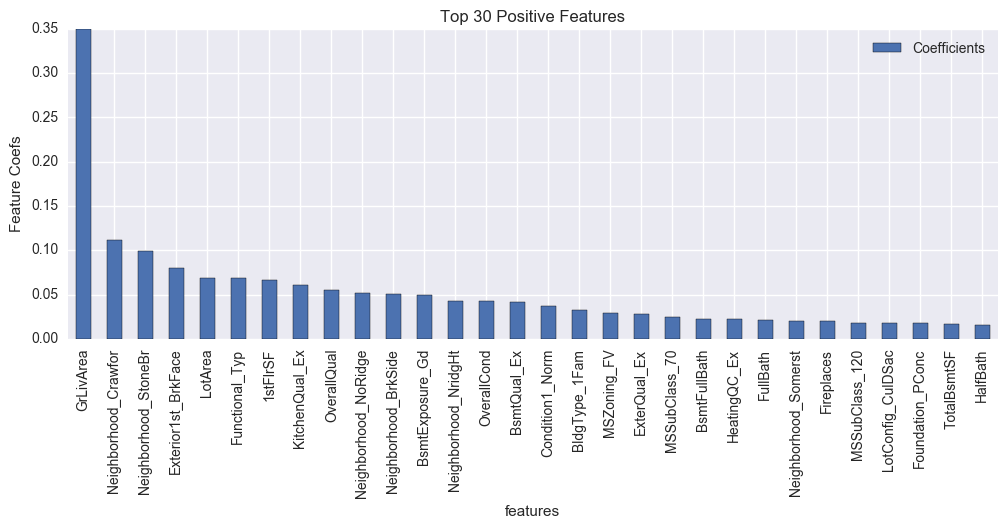

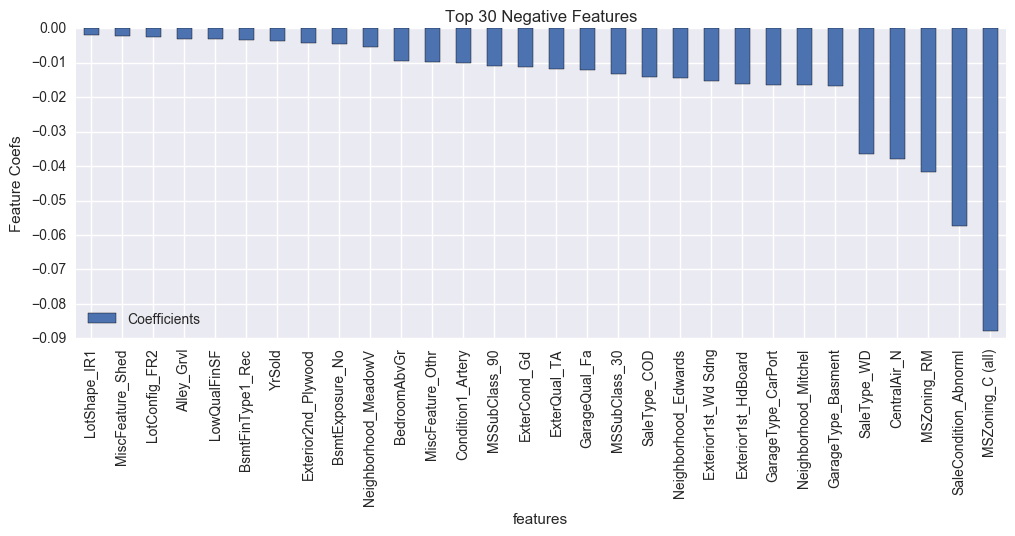

In [53]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

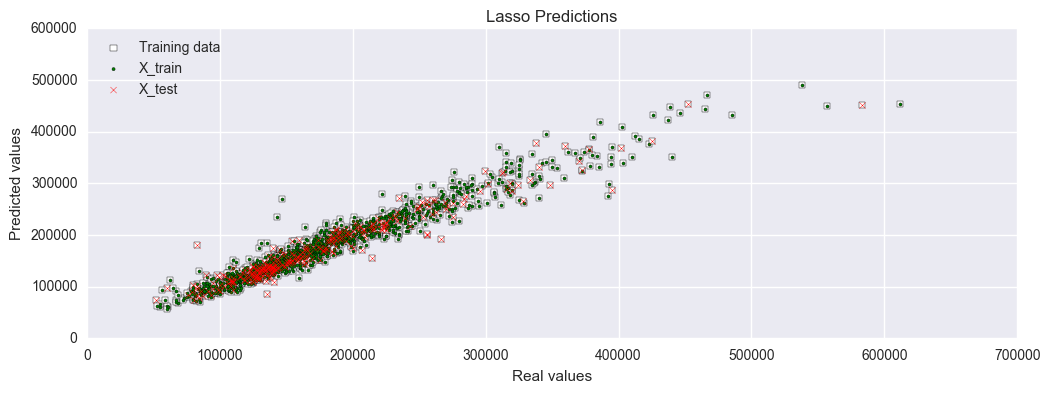

In [54]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(output.values), np.expm1(lasso.predict(train[features])), c = "white", marker = "s", label = "Training data")
plt.scatter(np.expm1(y_train.values), np.expm1(lasso.predict(X_train[features])), c = "green", marker = ".", label = "X_train")
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test[features])), c = "red", marker = "x", label = "X_test")

plt.title("Lasso Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

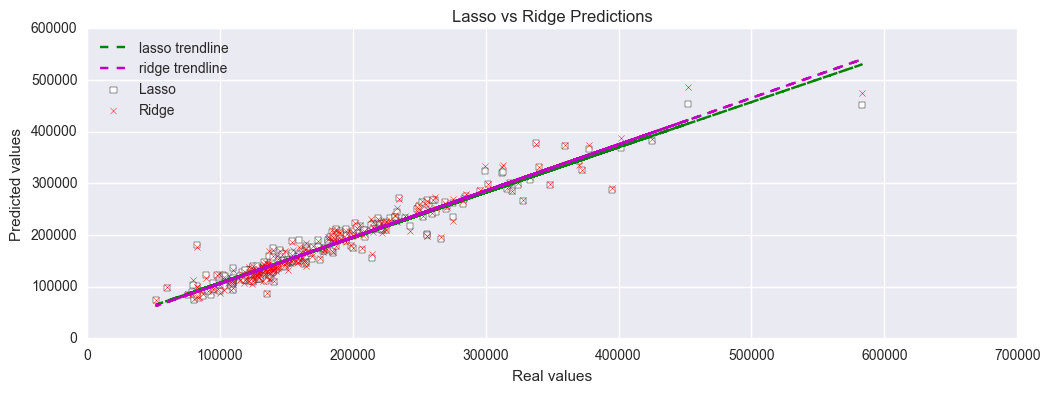

In [55]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test[features])), c = "white", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[features])), c = "red", marker = "x", label = "Ridge")
# calc the trendline
x = np.expm1(y_test.values)[:,0]
z = np.polyfit(x, np.expm1(lasso.predict(X_test[features])), 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--", label="lasso trendline")
z = np.polyfit(x, np.expm1(ridge.predict(X_test[features])[:,0]), 1)
r = np.poly1d(z)
plt.plot(x,r(x),"m--", label="ridge trendline")

plt.title("Lasso vs Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Looking at above, we can see that both Lasso and Ridge are predicting similar values. Also, the slope of both the trendlines are less than 1 so we are overall predicting lower values than actual. 

### Lets create polynomial features and run regression

In [56]:
#poly_2_features = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscFeature_Shed"]
poly_2_features = train.columns[train.dtypes == float]
#train[poly_2_features].head(2)

In [57]:
cols2drop = train.filter(regex='\*2').columns.values
train.drop(cols2drop, axis=1, inplace=True)

In [58]:
train.shape

(1434, 299)

In [59]:
for col in poly_2_features:
    train[str(col) + "**2"] = train[col]**2
    test[str(col) + "**2"] = test[col]**2

In [60]:
train.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

In [61]:
train.shape

(1434, 325)

**Lets save this data set**

In [62]:
train.to_csv("./../Data/train_engineered2_poly.csv")

In [63]:
output.to_csv("./../Data/output_engineered2_poly.csv")

In [64]:
test.to_csv("./../Data/test_engineered2_poly.csv")

In [65]:
train.shape, output.shape, test.shape

((1434, 325), (1434, 1), (1459, 325))

### Ridge Regression on Polynomial features

In [66]:
alpha = 10**np.random.uniform(-1,2, size=200)
print alpha

[  0.12198105  27.05106125  35.57229911   0.75433138   1.25883213
   0.33994904  10.40849902   3.45637014   0.16865023  22.04280628
   0.61483514   1.43003251   1.82034271   0.120486     2.58528537
  24.00224265  63.78501759   0.8080624   10.74263659  49.60285075
  72.74558455  22.21789103   0.35575999   0.90061459   0.12811689
   0.16763608  34.94981999   0.1529306    1.42566968   1.34309054
  16.24878932  63.1625354   49.96232622   1.52080136   0.35458949
   0.88646675   0.15300357  10.92962141  34.63343117  17.65743543
   0.58501152  75.27240906   0.15459219   0.57755717   3.39975057
  19.09387496   2.31991992   3.38227582  30.42602266   9.61377251
   0.15222238   0.82901502   2.42963608   9.64572643   0.22179343
  38.94088976   0.85841503   1.33384702   0.83654945   0.39858448
  15.71885054  31.70068874   0.15505825   0.14543533  12.27948922
  11.24003524  58.20885086  38.57639559  23.06688573   0.48240921
   4.21355277   9.52699096   1.82422506   0.54956755   0.99183196
   6.84879

In [67]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=27)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [68]:
ridge2 = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)

In [69]:
features = X_train.columns

In [70]:
features

Index([u'LotFrontage', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF',
       ...
       u'WoodDeckSF**2', u'OpenPorchSF**2', u'EnclosedPorch**2',
       u'3SsnPorch**2', u'ScreenPorch**2', u'PoolArea**2',
       u'MiscFeature_Gar2**2', u'MiscFeature_Othr**2', u'MiscFeature_Shed**2',
       u'MiscFeature_TenC**2'],
      dtype='object', length=325)


Model Report
Training R-Square: 0.947
Training RMSE : 0.088
Validation R-Square: 0.921
Validation RMSE : 0.106
Variance score: 0.92
Optimal Alpha: 18.9911
Training cv_score (R^2 and MSE):  
[ 0.90385849  0.93642139  0.92189104  0.93452962  0.91695433]
[-0.01139372 -0.00876317 -0.01212017 -0.01080217 -0.01200343]
CV Score (R^2) : Mean: 0.922731 | Std: 0.01197399 | Min: 0.9038585 | Max: 0.9364214
CV Score (MSE) : Mean: -0.01101653 | Std: 0.001221301 | Min: -0.01212017 | Max: -0.008763167


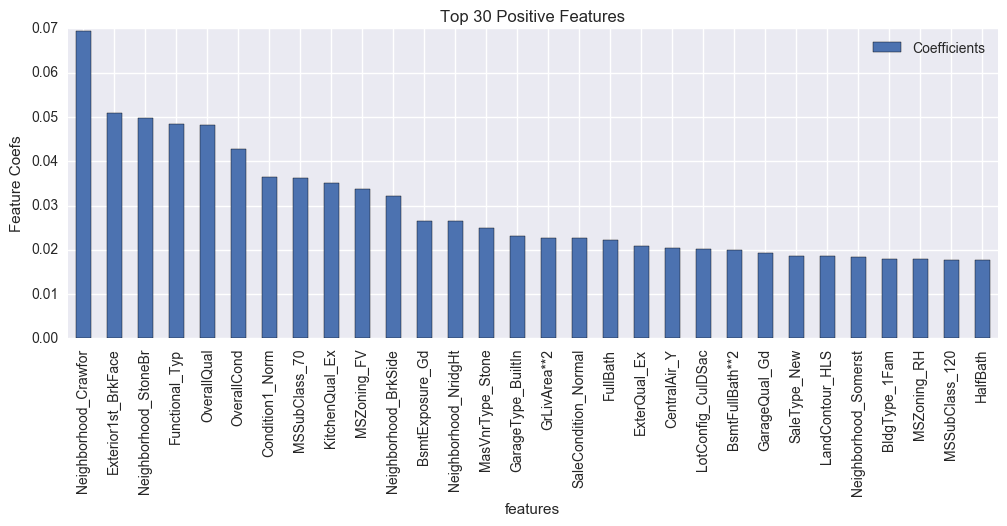

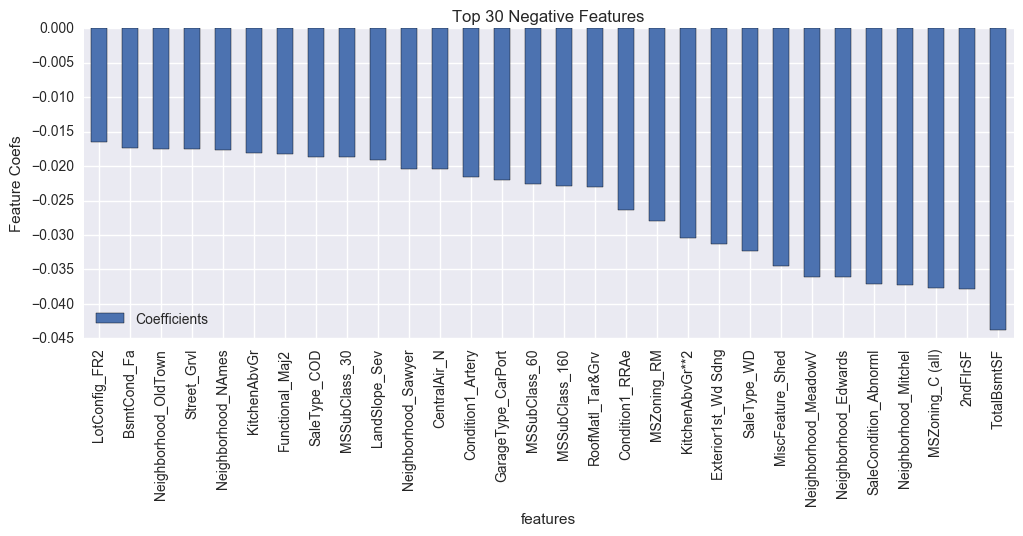

In [71]:
modelfit(ridge2, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=True)

In [72]:
# The coefficients
pd.set_option('display.max_rows', 500)
df = {'features': features, 'Coefficients': ridge2.coef_[0]}
ridge2_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
ridge2_coefficients

Coefficients               features
84   6.935080e-02   Neighborhood_Crawfor
150  5.084915e-02    Exterior1st_BrkFace
100  4.985068e-02   Neighborhood_StoneBr
249  4.845893e-02         Functional_Typ
2    4.812097e-02            OverallQual
3    4.267424e-02            OverallCond
105  3.647609e-02        Condition1_Norm
43   3.626107e-02          MSSubClass_70
239  3.518144e-02         KitchenQual_Ex
54   3.364819e-02            MSZoning_FV
81   3.210260e-02   Neighborhood_BrkSide
206  2.646234e-02        BsmtExposure_Gd
94   2.644400e-02   Neighborhood_NridgHt
181  2.492984e-02       MasVnrType_Stone
258  2.317123e-02     GarageType_BuiltIn
309  2.263316e-02           GrLivArea**2
297  2.259095e-02   SaleCondition_Normal
17   2.218088e-02               FullBath
182  2.091346e-02           ExterQual_Ex
233  2.041880e-02           CentralAir_Y
71   2.019576e-02      LotConfig_CulDSac
310  2.008043e-02        BsmtFullBath**2
266  1.931167e-02          GarageQual_Gd
290  1.865439e-02           SaleType_New
67   1.853712e-02        LandContour_HLS
99   1.844318e-02   Neighborhood_Somerst
120  1.796924e-02          BldgType_1Fam
55   1.785527e-02            MSZoning_RH
48   1.782696e-02         MSSubClass_120
18   1.781695e-02               HalfBath
59   1.746322e-02            Street_Pave
215  1.733269e-02       BsmtFinType2_ALQ
256  1.700505e-02      GarageType_Attchd
287  1.676216e-02         SaleType_ConLD
93   1.655574e-02   Neighborhood_NoRidge
193  1.648679e-02       Foundation_PConc
22   1.529797e-02             Fireplaces
176  1.465189e-02    Exterior2nd_Wd Sdng
61   1.454509e-02             Alley_Pave
56   1.422516e-02            MSZoning_RL
197  1.361560e-02            BsmtQual_Ex
23   1.353152e-02             GarageCars
227  1.242255e-02           HeatingQC_Ex
260  1.173171e-02      GarageType_Detchd
276  1.167258e-02           PavedDrive_Y
261  1.144909e-02       GarageFinish_Fin
217  1.131444e-02       BsmtFinType2_GLQ
194  1.079348e-02        Foundation_Slab
164  1.047356e-02    Exterior2nd_Brk Cmn
273  1.047116e-02          GarageCond_TA
252  1.035983e-02         FireplaceQu_Gd
107  1.030678e-02        Condition1_PosN
75   1.005511e-02          LandSlope_Gtl
264  9.945676e-03          GarageQual_Ex
269  9.945676e-03          GarageCond_Ex
211  9.902343e-03       BsmtFinType1_GLQ
305  9.636101e-03         TotalBsmtSF**2
41   9.629313e-03          MSSubClass_50
298  9.214204e-03  SaleCondition_Partial
76   9.128710e-03          LandSlope_Mod
254  8.577224e-03         FireplaceQu_TA
141  8.431624e-03       RoofMatl_Membran
250  8.136089e-03         FireplaceQu_Ex
126  8.044190e-03      HouseStyle_1.5Unf
294  8.041842e-03  SaleCondition_AdjLand
37   7.910411e-03          MSSubClass_20
27   7.777106e-03          EnclosedPorch
246  7.746854e-03        Functional_Min2
279  7.735165e-03              PoolQC_Gd
285  7.664829e-03           SaleType_CWD
187  7.260058e-03           ExterCond_Fa
115  7.104304e-03        Condition2_PosA
158  6.931275e-03     Exterior1st_Stucco
186  6.885953e-03           ExterCond_Ex
282  6.759930e-03            Fence_MnPrv
307  6.468306e-03            2ndFlrSF**2
102  6.444673e-03   Neighborhood_Veenker
63   6.117419e-03           LotShape_IR2
111  6.060994e-03        Condition1_RRNn
138  6.042150e-03         RoofStyle_Shed
209  6.004903e-03       BsmtFinType1_ALQ
204  5.867662e-03            BsmtCond_TA
235  5.535769e-03       Electrical_FuseF
114  5.379511e-03        Condition2_Norm
179  5.275882e-03     MasVnrType_BrkFace
132  5.205313e-03        HouseStyle_SLvl
124  5.146838e-03        BldgType_TwnhsE
323  5.067512e-03    MiscFeature_Shed**2
149  5.022416e-03    Exterior1st_BrkComm
140  4.895459e-03       RoofMatl_CompShg
288  4.854407e-03         SaleType_ConLI
271  4.839175e-03          GarageCond_Gd
222  4.831802e-03           Heating_GasA
80   4.647407e-03    Neighborhood_BrDale
165  4.532613e-03    Exterior2nd_BrkFace
96   4.508655e-03     Neighborhood_SWISU
159  4.362063e-03    Exterio

In [73]:
X_test.shape

(287, 325)

In [74]:
train.filter(regex='\*2').columns.values

array(['LotFrontage**2', 'LotArea**2', 'MasVnrArea**2', 'BsmtFinSF1**2',
       'BsmtFinSF2**2', 'BsmtUnfSF**2', 'TotalBsmtSF**2', '1stFlrSF**2',
       '2ndFlrSF**2', 'LowQualFinSF**2', 'GrLivArea**2', 'BsmtFullBath**2',
       'BsmtHalfBath**2', 'KitchenAbvGr**2', 'GarageCars**2',
       'GarageArea**2', 'WoodDeckSF**2', 'OpenPorchSF**2',
       'EnclosedPorch**2', '3SsnPorch**2', 'ScreenPorch**2', 'PoolArea**2',
       'MiscFeature_Gar2**2', 'MiscFeature_Othr**2', 'MiscFeature_Shed**2',
       'MiscFeature_TenC**2'], dtype=object)

In [75]:
non_poly_features = [x for x in X_train.columns if x not in X_train.filter(regex='\*2').columns.values]

In [76]:
X_test[non_poly_features].shape

(287, 299)

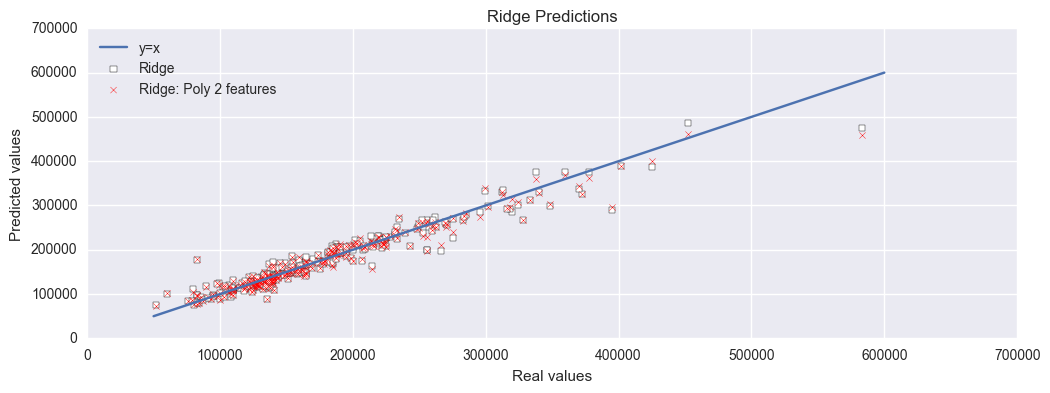

In [77]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[non_poly_features])), c = "white", marker = "s", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test[features])), c = "red", marker = "x", label = "Ridge: Poly 2 features")
plt.plot([50000, 600000], [50000, 600000], label="y=x")

plt.title("Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

**Looking at above, ridge regression with some polynomial features perhaps does slightly better but the improvement is very small. Also, at larger values of output, errors are larger which is a concern!**

**Lets plot predictions against real values for some of the features**

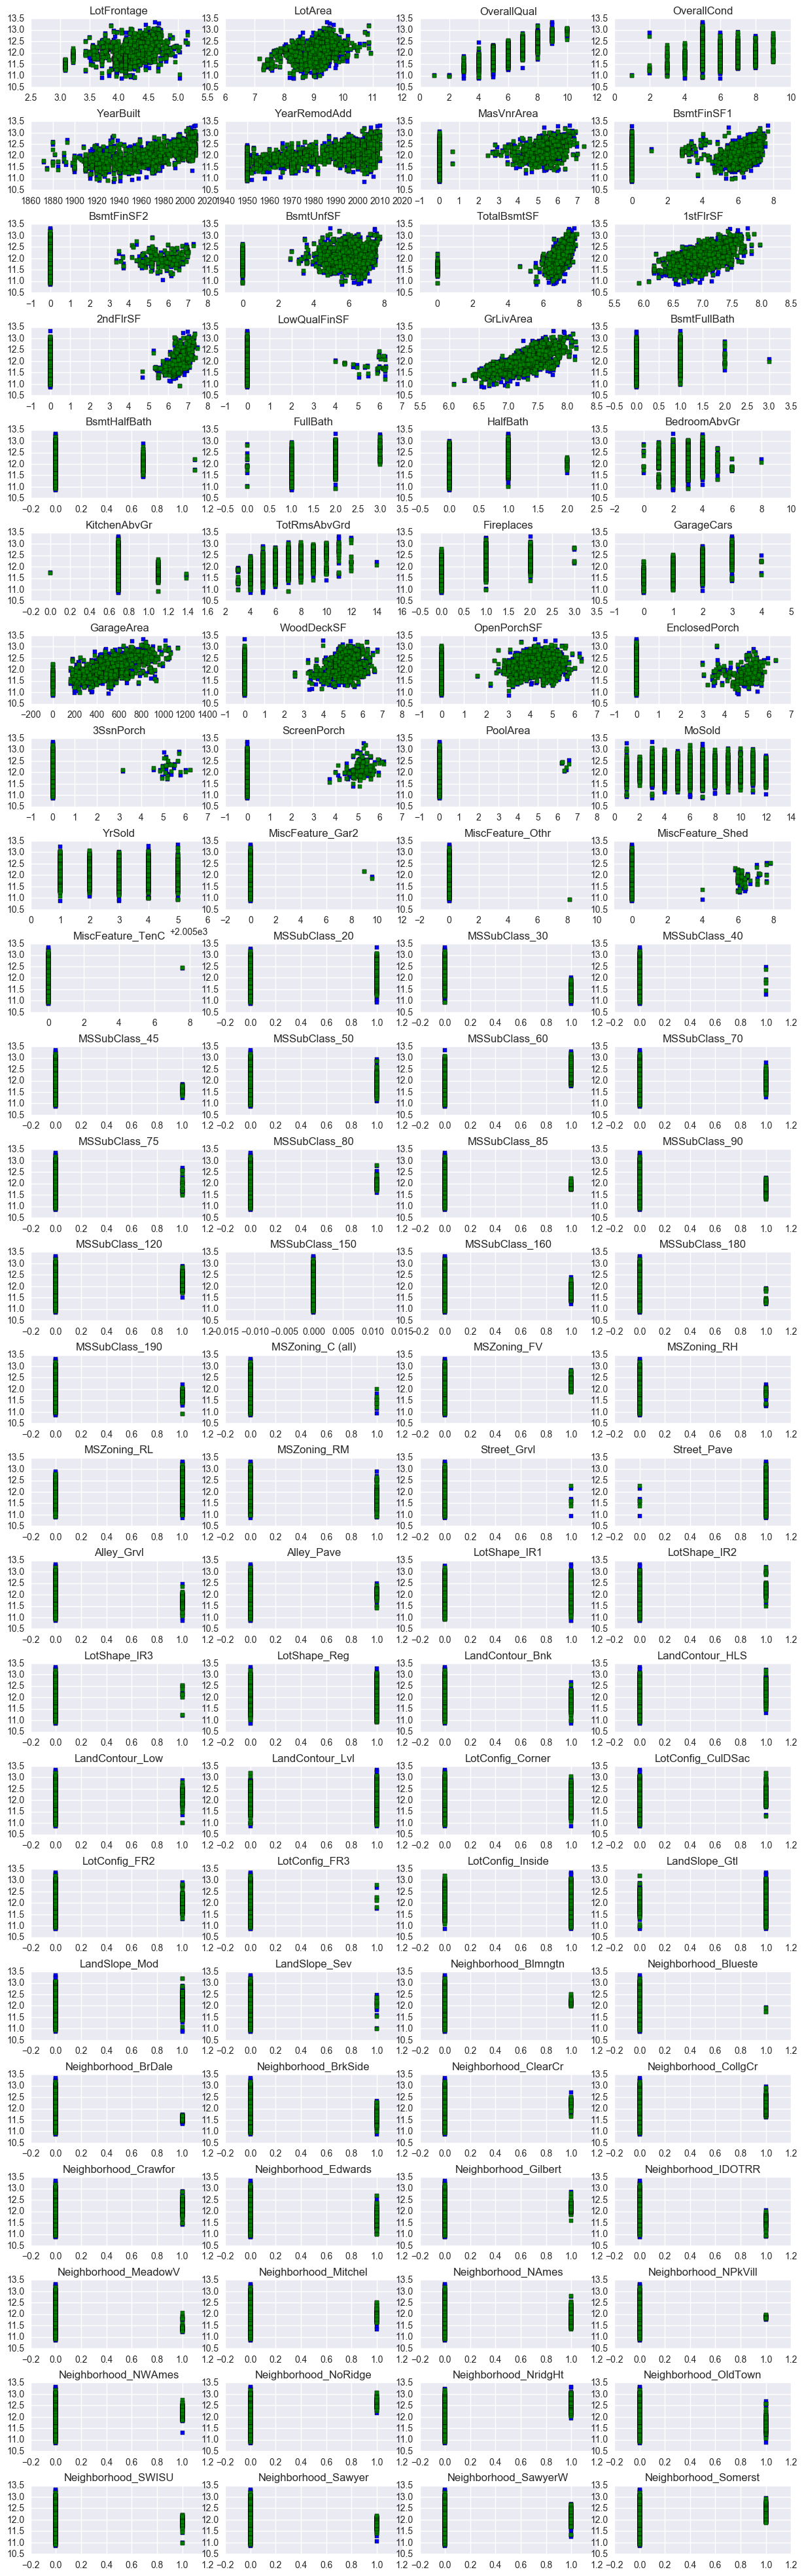

In [78]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i]].values, output.values, c = "blue", marker = "s")
    axs[i].scatter(train[train.columns[i]].values, ridge2.predict(train), c = "green", marker = "s")
    axs[i].set_title(train.columns[i])


### Lets try Lasso with polynomial features

In [79]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)
alpha

array([  9.73796196e+00,   3.67953738e-06,   6.07629753e+00,
         8.72089857e-01,   1.74345398e-01,   1.68078679e-02,
         2.48128935e-05,   1.23399710e-02,   1.38731682e-06,
         3.36382739e-06,   1.19557864e-06,   4.86091683e-01,
         6.16515660e-06,   4.42701053e+00,   2.84457725e-03,
         1.93476176e-02,   6.05090337e-04,   8.75399882e+00,
         2.35619739e-04,   3.85349151e-06,   1.10366375e-02,
         4.42978080e-02,   4.04519829e-02,   9.74758587e-03,
         2.55262191e-03,   1.35849299e-06,   3.72545050e-04,
         5.25852847e-01,   2.88441207e-02,   3.99276976e-02,
         1.29075613e-03,   9.14816773e-01,   2.34468647e-02,
         1.64960307e-01,   3.98672876e-04,   1.29421518e-06,
         2.39780345e-04,   1.70884974e-03,   8.57875263e-02,
         2.91470676e-01,   5.65391859e-02,   2.45639158e+00,
         1.10405153e-02,   5.23777672e-04,   2.34251031e-01,
         3.24973842e+00,   1.27504314e+00,   6.75169561e-01,
         3.16927806e-06,

In [80]:
lasso2 = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [81]:
modelfit(lasso2, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)


Model Report
Training R-Square: 0.944
Training RMSE : 0.090
Validation R-Square: 0.918
Validation RMSE : 0.108
Variance score: 0.92
Optimal Alpha: 0.0005
Training cv_score (R^2 and MSE):  
[ 0.90049833  0.93716441  0.92586803  0.93575811  0.91870164]
[-0.01179193 -0.00866076 -0.01150306 -0.01059948 -0.01175088]
CV Score (R^2) : Mean: 0.9235981 | Std: 0.01337638 | Min: 0.9004983 | Max: 0.9371644
CV Score (MSE) : Mean: -0.01086122 | Std: 0.001181544 | Min: -0.01179193 | Max: -0.008660756


In [82]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso2.coef_}
lasso_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients

Coefficients               features
84   1.100048e-01   Neighborhood_Crawfor
100  8.173383e-02   Neighborhood_StoneBr
150  7.767716e-02    Exterior1st_BrkFace
249  6.448752e-02         Functional_Typ
239  5.239390e-02         KitchenQual_Ex
81   5.154861e-02   Neighborhood_BrkSide
2    4.956519e-02            OverallQual
54   4.429601e-02            MSZoning_FV
3    4.388266e-02            OverallCond
105  3.822746e-02        Condition1_Norm
206  3.734269e-02        BsmtExposure_Gd
94   3.000173e-02   Neighborhood_NridgHt
43   2.527536e-02          MSSubClass_70
197  2.498371e-02            BsmtQual_Ex
309  2.323018e-02           GrLivArea**2
193  2.130336e-02       Foundation_PConc
182  2.075794e-02           ExterQual_Ex
227  1.817177e-02           HeatingQC_Ex
71   1.790251e-02      LotConfig_CulDSac
181  1.769490e-02       MasVnrType_Stone
22   1.669804e-02             Fireplaces
17   1.664809e-02               FullBath
93   1.505851e-02   Neighborhood_NoRidge
310  1.400440e-02        BsmtFullBath**2
305  1.395166e-02         TotalBsmtSF**2
258  1.259324e-02     GarageType_BuiltIn
67   1.213956e-02        LandContour_HLS
120  1.203804e-02          BldgType_1Fam
273  1.136751e-02          GarageCond_TA
18   1.002793e-02               HalfBath
261  8.802911e-03       GarageFinish_Fin
256  7.996972e-03      GarageType_Attchd
313  6.535377e-03          GarageCars**2
297  5.999187e-03   SaleCondition_Normal
276  5.864240e-03           PavedDrive_Y
307  5.766357e-03            2ndFlrSF**2
323  5.051731e-03    MiscFeature_Shed**2
21   3.972088e-03           TotRmsAbvGrd
252  3.877464e-03         FireplaceQu_Gd
246  3.674006e-03        Functional_Min2
320  3.606960e-03            PoolArea**2
316  3.490895e-03         OpenPorchSF**2
300  3.435779e-03             LotArea**2
155  3.353491e-03    Exterior1st_MetalSd
48   3.351518e-03         MSSubClass_120
282  3.285294e-03            Fence_MnPrv
99   3.237166e-03   Neighborhood_Somerst
159  3.229068e-03    Exterior1st_VinylSd
306  2.602195e-03            1stFlrSF**2
4    2.283384e-03              YearBuilt
301  2.264342e-03          MasVnrArea**2
204  1.975240e-03            BsmtCond_TA
315  1.645035e-03          WoodDeckSF**2
302  1.440130e-03          BsmtFinSF1**2
176  1.389588e-03    Exterior2nd_Wd Sdng
319  1.370594e-03         ScreenPorch**2
299  1.074688e-03         LotFrontage**2
9    9.765002e-04              BsmtUnfSF
254  9.651180e-04         FireplaceQu_TA
70   8.277573e-04       LotConfig_Corner
303  7.567462e-04          BsmtFinSF2**2
5    7.063284e-04           YearRemodAdd
317  6.965726e-04       EnclosedPorch**2
136  6.940569e-04          RoofStyle_Hip
318  6.394921e-04           3SsnPorch**2
290  3.233672e-04           SaleType_New
215  2.207041e-04       BsmtFinType2_ALQ
24   5.127039e-05             GarageArea
314  5.342846e-08          GarageArea**2
233  5.206724e-18           CentralAir_Y
219 -0.000000e+00       BsmtFinType2_Rec
207 -0.000000e+00        BsmtExposure_Mn
209  0.000000e+00       BsmtFinType1_ALQ
218 -0.000000e+00       BsmtFinType2_LwQ
220  0.000000e+00       BsmtFinType2_Unf
210  0.000000e+00       BsmtFinType1_BLQ
211  0.000000e+00       BsmtFinType1_GLQ
205 -0.000000e+00        BsmtExposure_Av
217  0.000000e+00       BsmtFinType2_GLQ
216 -0.000000e+00       BsmtFinType2_BLQ
212 -0.000000e+00       BsmtFinType1_LwQ
214 -0.000000e+00       BsmtFinType1_Unf
0    0.000000e+00            LotFrontage
183 -0.000000e+00           ExterQual_Fa
203 -0.000000e+00            BsmtCond_Po
222  0.000000e+00           Heating_GasA
168 -0.000000e+00    Exterior2nd_HdBoard
169  0.000000e+00    Exterior2nd_ImStucc
170  0.000000e+00    Exterior2nd_MetalSd
171 -0.000000e+00      Exterior2nd_Other
173 -0.000000e+00      Exterior2nd_Stone
174  0.000000e+00     Exterior2nd_Stucco
175  0.000000e+00    Exterior2nd_VinylSd
177 -0.000000e+00    Exterior2nd_Wd Shng
178 -0.000000e+00      MasVnrType_BrkCmn
179  0.000000e+00     MasVnrType_BrkFace
180  0.000000e+00        Mas

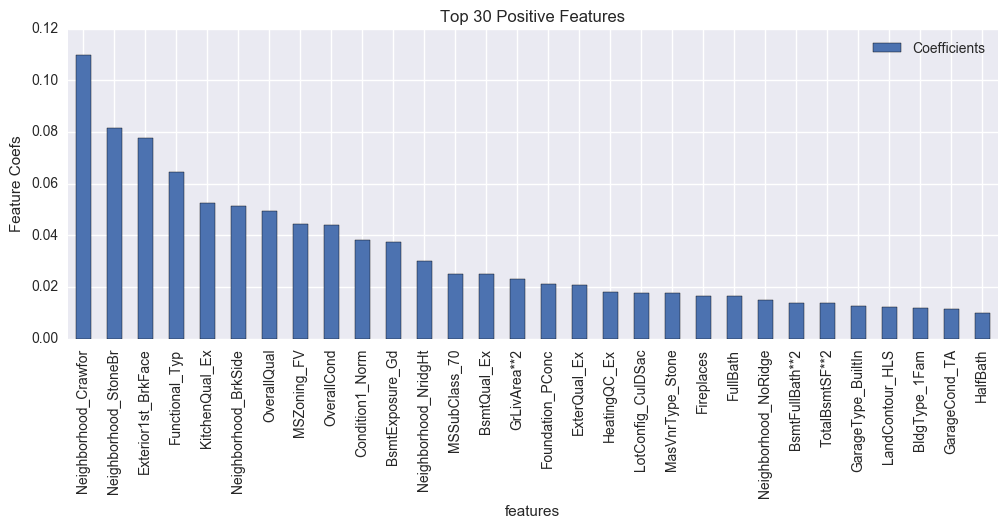

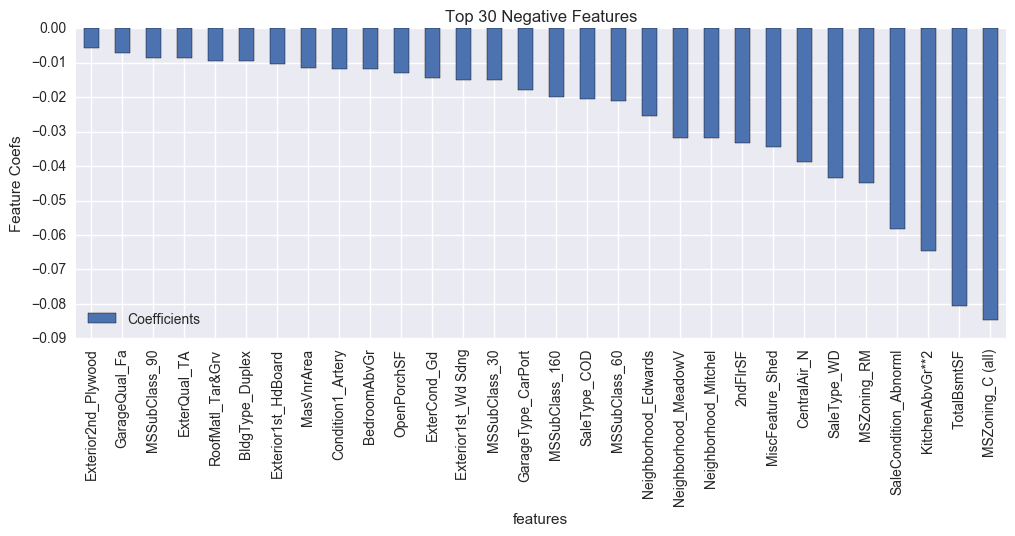

In [83]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

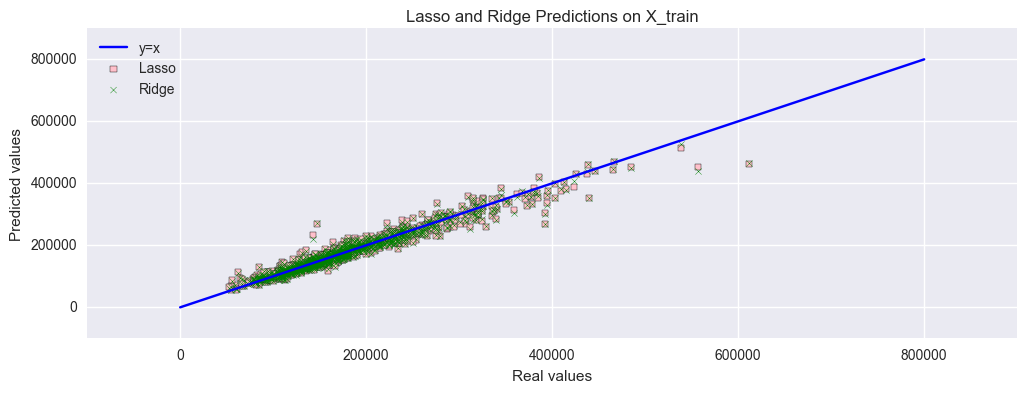

In [84]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_train.values), np.expm1(lasso2.predict(X_train)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_train.values), np.expm1(ridge2.predict(X_train)), c = "green", marker = "x", label = "Ridge")
plt.plot([0,800000],[0,800000], c="blue", label="y=x" )
plt.title("Lasso and Ridge Predictions on X_train")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Even for training data, errors increase for larger values of output and it looks like we are mostly predicting lower values.

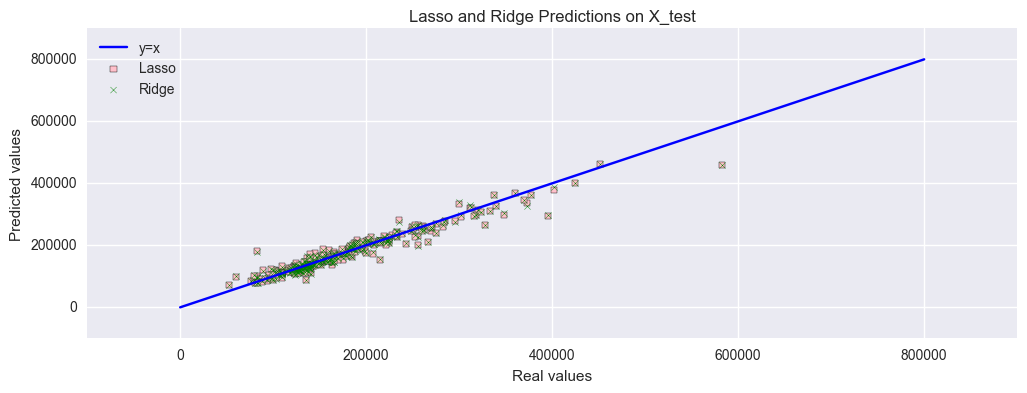

In [85]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "x", label = "Ridge")
plt.plot([0,800000],[0,800000], c="blue", label="y=x" )
plt.title("Lasso and Ridge Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

## Gradient Boosting

We obtain hyperparameters from this notebook: https://github.com/ptiwaree/Kaggle-HousePrices/blob/master/House%20Prices%20-%20Boosting-3.ipynb

Optimal parameters used come from using gridsearch in the above notebook.

In [86]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions

In [87]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

I adjusted the below parameters slightly from the notebook as it produces better cv results.

In [88]:
min_samples_split = 0.001
min_samples_leaf = 27 
max_depth = 3
max_features = 22
subsample = 0.8
n_estimators=30000
learning_rate=0.0015

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
R-Square: 0.972
RMSE : 0.064
cv_score: 
[ 0.90277735  0.93026933  0.91668064  0.93190094  0.90860535]
CV Score : Mean: 0.9180467 | Std: 0.01153682 | Min: 0.9027773 | Max: 0.9319009


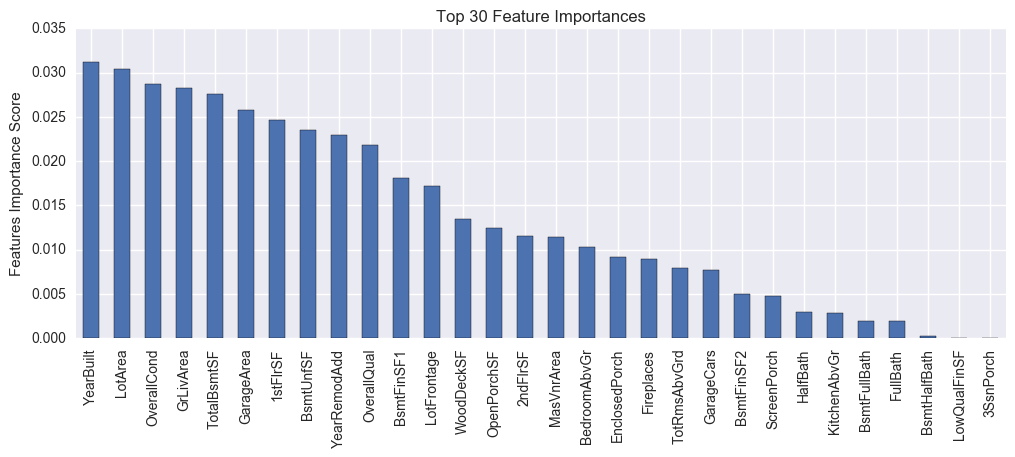

In [89]:
gbm = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm, X_train, features, y_train.values)

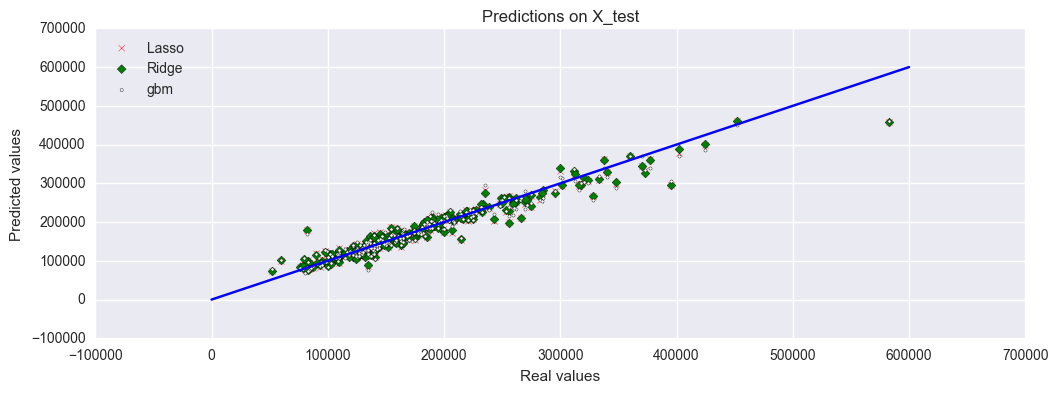

In [90]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "red", marker = "x", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "D", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "white", marker = ".", label = "gbm")
plt.plot([0,600000],[0,600000], c="blue" )
plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

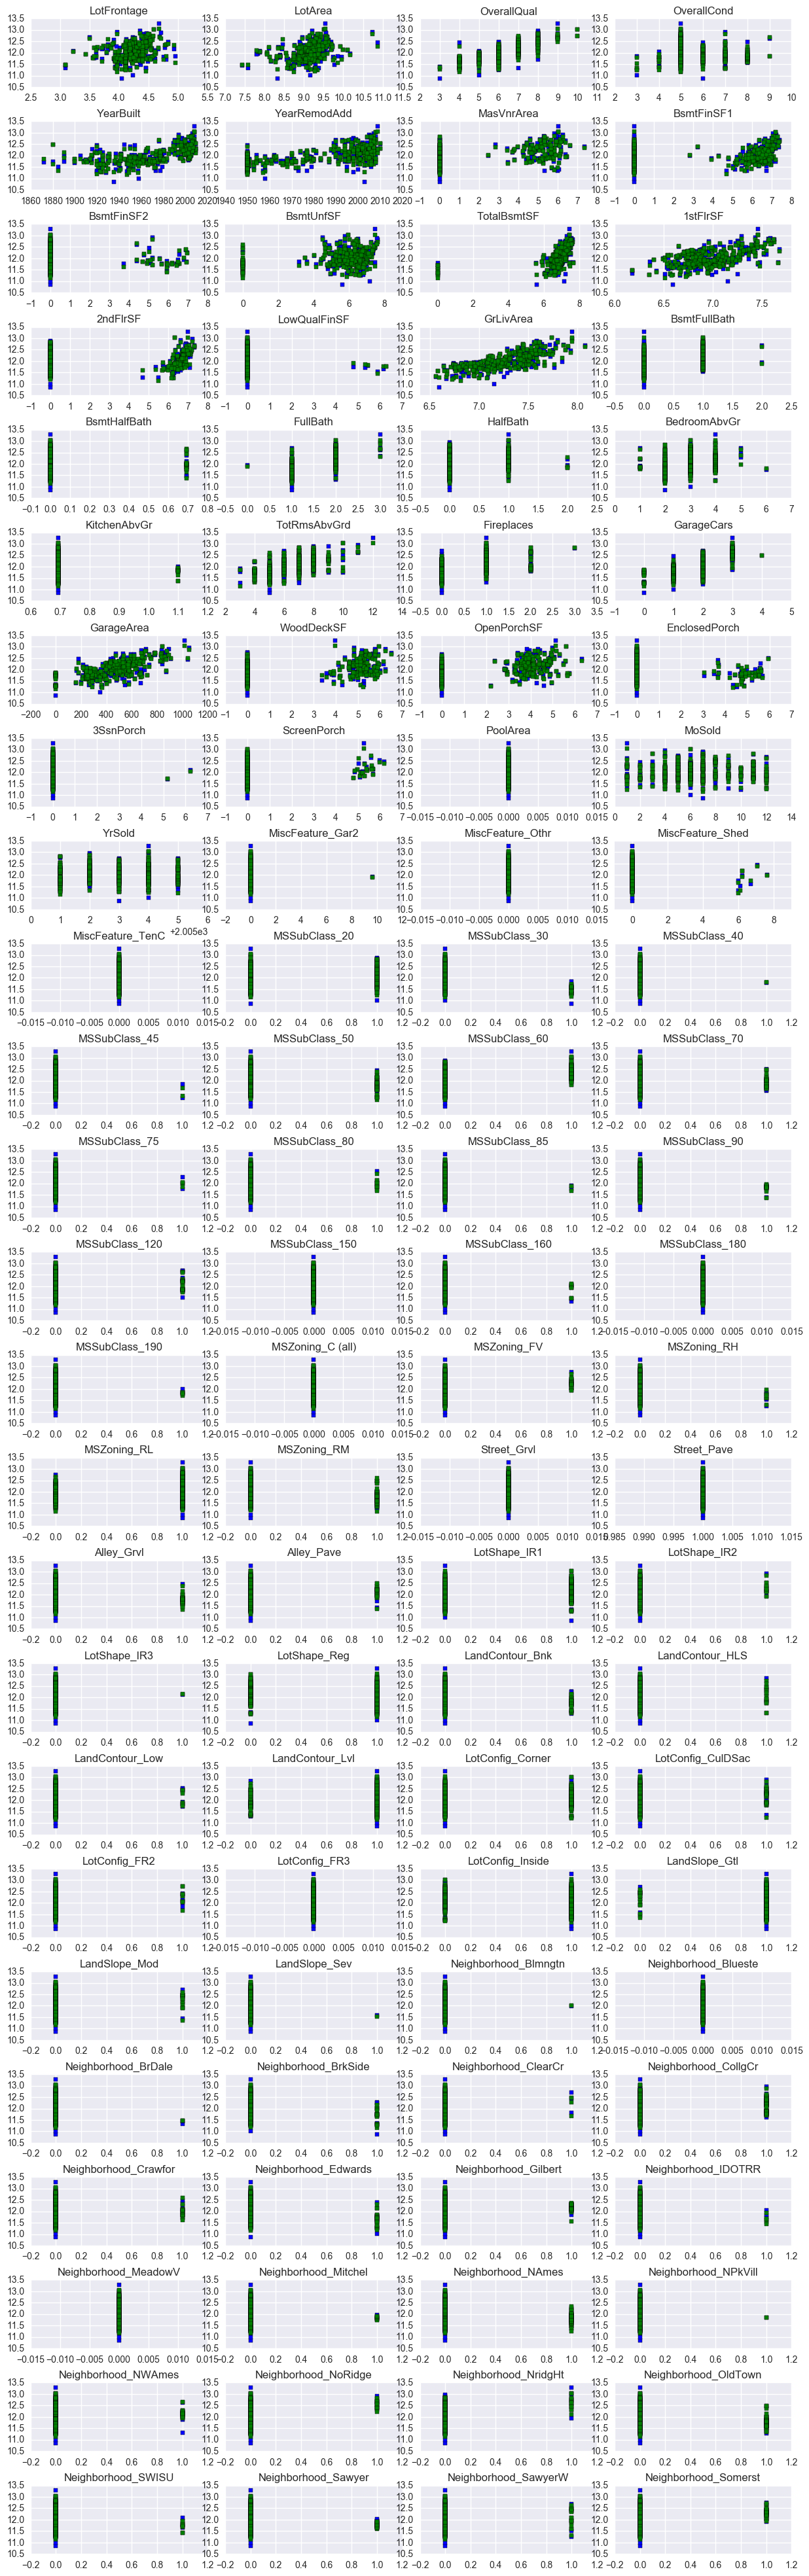

In [91]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(X_test[X_test.columns[i]].values, y_test.values, c = "blue", marker = "s")
    axs[i].scatter(X_test[X_test.columns[i]].values, gbm.predict(X_test), c = "green", marker = "s")
    axs[i].set_title(train.columns[i])

### Lets take a median of the neighborhood and see how well it makes predictions

In [92]:
X_train.head(3)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
939      4.400603  10.089594            7            7       1940   
1430     4.110874   9.995656            5            5       2005   
40       4.442651   9.066355            6            5       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
939           1950    0.000000    0.000000         0.0   6.940222   
1430          2005    0.000000    0.000000         0.0   6.597146   
40            1965    4.624973    6.467699         0.0   6.100319   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
939      6.940222  7.096721  7.087574           0.0   7.784889           0.0   
1430     6.597146  6.599870  7.007601           0.0   7.516977           0.0   
40       6.993015  7.189168  0.000000           0.0   7.189168           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
939            0.0         2         0             4      0.693147   
1430           0.0         2         1             4      0.693147   
40             0.0         2         0             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
939             10           2         1.0       349.0    4.043051   
1430             7           1         2.0       372.0    4.615121   
40               6           1         2.0       440.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
939      0.000000       5.765191        0.0          0.0       0.0       6   
1430     3.713572       0.000000        0.0          0.0       0.0       7   
40       4.934474       0.000000        0.0          0.0       0.0      12   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
939     2010               0.0               0.0               0.0   
1430    2006               0.0               0.0               0.0   
40      2006               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
939                0.0              0              0              0   
1430               0.0              0              0              0   
40                 0.0              1              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
939               0              0              0              1   
1430              0              0              1              0   
40                0              0              0              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
939               0              0              0              0   
1430              0              0              0              0   
40                0              0              0              0   

      MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  \
939                0               0               0               0   
1430               0               0               0               0   
40                 0               0               0               0   

      MSSubClass_190  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
939                0                 0            0            0            1   
1430               0                 0            0            0            1   
40                 0                 0            0            0            1   

      MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  \
939             0            0            1           0           0   
1430            0            0            1           0           0   
40              0            0            1           0           0   

      LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  \
939              0             0             0             1                0   
1430             0             0             1             0                0   
40

In [93]:
X_train.shape, y_train.shape

((1147, 325), (1147, 1))

In [94]:
df = pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index])

In [95]:
df.shape

(1147, 326)

In [96]:
df.head(5)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
939      4.400603  10.089594            7            7       1940   
1430     4.110874   9.995656            5            5       2005   
40       4.442651   9.066355            6            5       1965   
952      4.110874   8.881975            5            8       1972   
1265     3.583519   8.225771            7            5       1999   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
939           1950    0.000000    0.000000         0.0   6.940222   
1430          2005    0.000000    0.000000         0.0   6.597146   
40            1965    4.624973    6.467699         0.0   6.100319   
952           2003    0.000000    6.493754         0.0   4.691348   
1265          1999    5.389072    6.111467         0.0   5.488938   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
939      6.940222  7.096721  7.087574           0.0   7.784889           0.0   
1430     6.597146  6.599870  7.007601           0.0   7.516977           0.0   
40       6.993015  7.189168  0.000000           0.0   7.189168           0.0   
952      6.645091  6.645091  0.000000           0.0   6.645091           0.0   
1265     6.539586  6.570883  6.606650           0.0   7.281386           1.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
939       0.000000         2         0             4      0.693147   
1430      0.000000         2         1             4      0.693147   
40        0.000000         2         0             3      0.693147   
952       0.693147         1         0             2      0.693147   
1265      0.000000         2         1             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
939             10           2         1.0       349.0    4.043051   
1430             7           1         2.0       372.0    4.615121   
40               6           1         2.0       440.0    0.000000   
952              5           0         1.0       396.0    5.262690   
1265             6           0         2.0       506.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
939      0.000000       5.765191        0.0          0.0       0.0       6   
1430     3.713572       0.000000        0.0          0.0       0.0       7   
40       4.934474       0.000000        0.0          0.0       0.0      12   
952      0.000000       0.000000        0.0          0.0       0.0       4   
1265     3.555348       0.000000        0.0          0.0       0.0       3   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
939     2010               0.0               0.0               0.0   
1430    2006               0.0               0.0               0.0   
40      2006               0.0               0.0               0.0   
952     2009               0.0               0.0               0.0   
1265    2006               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
939                0.0              0              0              0   
1430               0.0              0              0              0   
40                 0.0              1              0              0   
952                0.0              0              0              0   
1265               0.0              0              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
939               0              0              0              1   
1430              0              0              1              0   
40                0              0              0              0   
952               0              0              0              0   
1265              0              0              0              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
939               0              0              0          

In [97]:
df['Neighborhood'] = df[df.filter(regex='Neighborhood').columns.values].idxmax(1) #reverse one hot encoding

In [98]:
neighborhood_median_price = df.groupby(['Neighborhood'])['log_SalePrice'].median()

In [99]:
neighborhood_median_price

Neighborhood
Neighborhood_Blmngtn    12.162645
Neighborhood_Blueste    11.826543
Neighborhood_BrDale     11.598733
Neighborhood_BrkSide    11.706027
Neighborhood_ClearCr    12.160020
Neighborhood_CollgCr    12.206430
Neighborhood_Crawfor    12.300250
Neighborhood_Edwards    11.736077
Neighborhood_Gilbert    12.099786
Neighborhood_IDOTRR     11.575910
Neighborhood_MeadowV    11.385103
Neighborhood_Mitchel    11.957618
Neighborhood_NAmes      11.860056
Neighborhood_NPkVill    11.894782
Neighborhood_NWAmes     12.106258
Neighborhood_NoRidge    12.577640
Neighborhood_NridgHt    12.659737
Neighborhood_OldTown    11.669510
Neighborhood_SWISU      11.849405
Neighborhood_Sawyer     11.813037
Neighborhood_SawyerW    12.100440
Neighborhood_Somerst    12.329841
Neighborhood_StoneBr    12.529955
Neighborhood_Timber     12.360664
Neighborhood_Veenker    12.351656
Name: log_SalePrice, dtype: float64

In [100]:
X_test_median_pred = neighborhood_median_price[X_test[X_test.filter(regex='Neighborhood').columns.values].idxmax(1)] #reverse one hot encoding

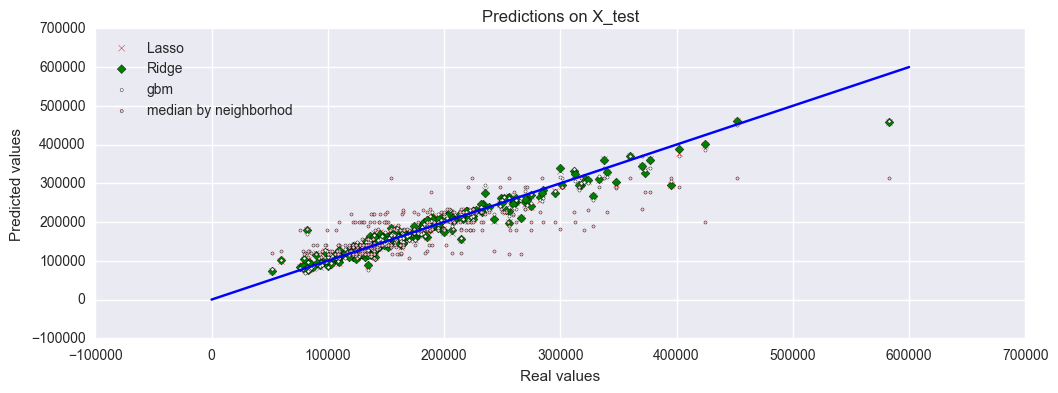

In [101]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "red", marker = "x", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "D", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "white", marker = ".", label = "gbm")
plt.plot([0,600000],[0,600000], c="blue" )
plt.scatter(np.expm1(y_test.values), np.expm1(X_test_median_pred), c = "pink", marker = ".", label = "median by neighborhod")

plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Median does a lot worse!

### ExtraTreesRegressor

In [105]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

In [102]:
from sklearn.ensemble import ExtraTreesRegressor

In [103]:
min_samples_split = 0.001000
min_samples_leaf = 1
max_depth = 16
max_features = 78
n_estimators = 330

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1665: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



Model Report
R-Square: 0.999
RMSE : 0.009
cv_score: 
[ 0.8744816   0.90653768  0.87166391  0.88637647  0.86962874]
CV Score : Mean: 0.8817377 | Std: 0.01369172 | Min: 0.8696287 | Max: 0.9065377


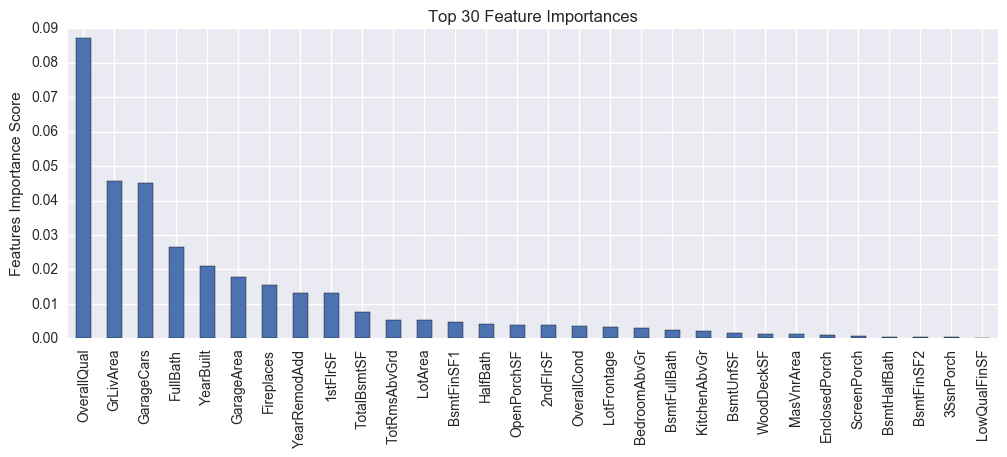

In [106]:
trees = ExtraTreesRegressor(n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf, 
                            random_state=77, 
                            max_features=max_features)
modelfit(trees, X_train, features, y_train.values)

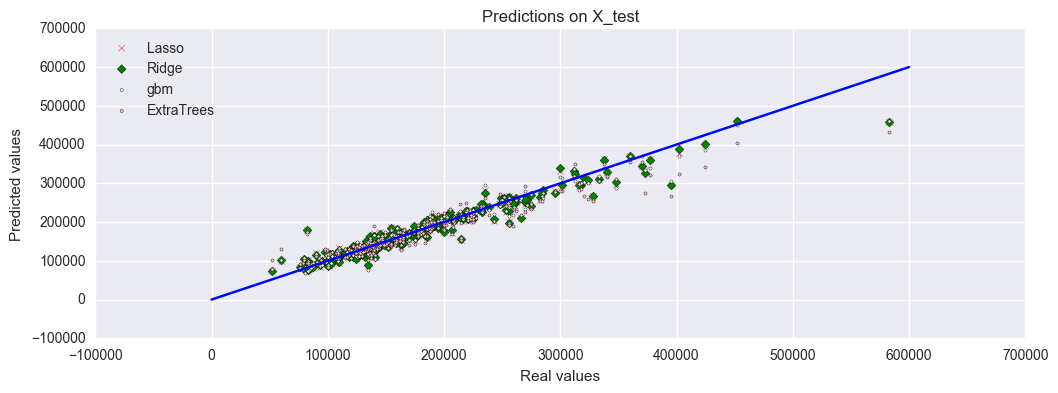

In [124]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "red", marker = "x", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "D", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "white", marker = ".", label = "gbm")
plt.plot([0,600000],[0,600000], c="blue" )
plt.scatter(np.expm1(y_test.values), np.expm1(trees.predict(X_test)), c = "pink", marker = ".", label = "ExtraTrees")

plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

ExtraTrees does worse for larger values and has bigger errors!

### Lets make some predictions before we do stacking

In [108]:
house_prices_test = pd.read_csv('test.csv')
house_prices_test.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       1961.0          Unf         1.0       730.0         TA   
1     Attchd       1958.0          Unf         1.0       312.0         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y         140            0              0          0   
1         TA          Y         393           36              0          0   

   ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold  \
0          120         0    NaN  MnPrv         NaN        0       6    2010   
1            0         0    NaN    NaN        Gar2    12500       6    2010   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal

In [109]:
house_prices_test.shape, test.shape, train.shape

((1459, 80), (1459, 325), (1434, 325))

In [110]:
house_prices_test['Id'].values

array([1461, 1462, 1463, ..., 2917, 2918, 2919])

In [125]:
pred1 = np.expm1(ridge2.predict(test)[:,0]/3.0 + lasso2.predict(test)/3.0 + gbm.predict(test)/3.0)
#pred1
pred1 = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred1})
pred1.head(5)

Id      SalePrice
0  1461  124900.979439
1  1462  150391.118914
2  1463  186491.878488
3  1464  198757.005935
4  1465  193869.451056

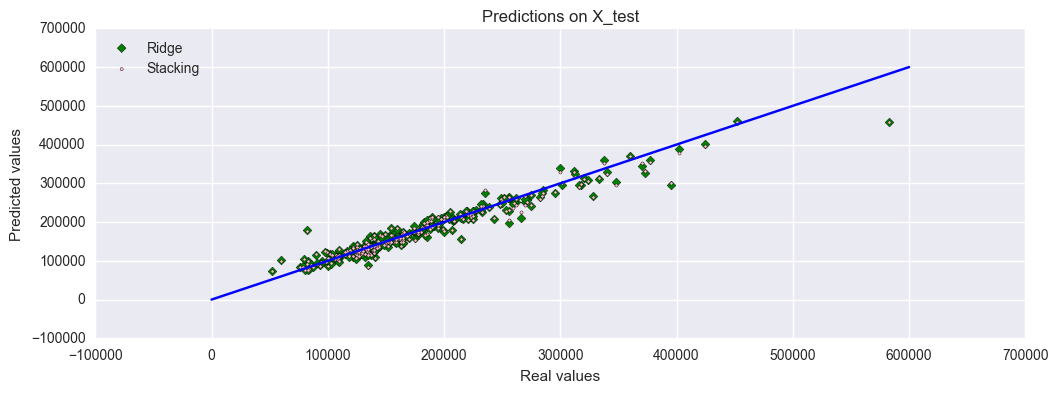

In [126]:
#plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "red", marker = "x", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "D", label = "Ridge")
#plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "white", marker = ".", label = "gbm")
plt.plot([0,600000],[0,600000], c="blue" )
temp = np.expm1(ridge2.predict(X_test)[:,0]/3.0 + lasso2.predict(X_test)/3.0 + gbm.predict(X_test)/3.0)
plt.scatter(np.expm1(y_test.values), temp, c = "pink", marker = ".", label = "Stacking")
plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

In [127]:
pred1.to_csv('kaggle_submission_lassoridgegbm_Jan292017.csv', index=False)

In [135]:
pred1[pred1.SalePrice > 400000]

Id      SalePrice
19    1480  497072.552405
200   1661  436839.823447
203   1664  487120.773627
211   1672  426129.314710
217   1678  472088.568354
245   1706  416431.253572
507   1968  411737.763895
509   1970  416834.551797
510   1971  477240.030605
514   1975  528212.306638
701   2162  403258.552037
803   2264  472143.352832
807   2268  423899.519384
829   2290  461865.836198
831   2292  444719.877484
832   2293  464999.841857
834   2295  492903.396296
879   2340  417836.037053
1089  2550  793515.973988
1167  2628  478990.293687
1168  2629  495674.980856
1170  2631  480311.018445
1171  2632  411427.001585
1173  2634  425987.112347
1194  2655  426050.861358
1222  2683  500741.202923
1229  2690  426212.975972

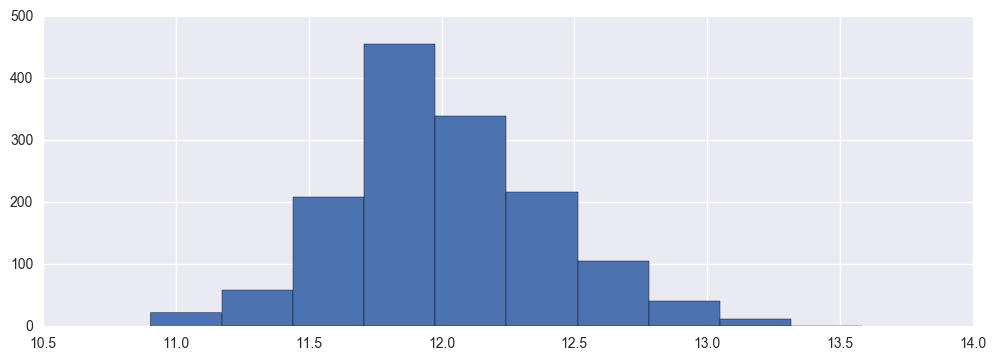

In [137]:
np.log1p(pred1.SalePrice).hist()

## Model Stacking (aka Meta Ensemble)

http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

### STEP 1:
#### Partition the training data into five test folds
#### Create a dataset called train_meta with the same row Ids and fold Ids as the training dataset, with empty columns M1 and M2. Similarly create a dataset called test_meta with the same row Ids as the test dataset and empty columns M1 and M2

In [138]:
#train_meta = train #this doesnt work. it creates a common pointer but we want a copy
train_meta = train.copy(deep=True)

In [139]:
train_meta.shape, train.shape

((1434, 325), (1434, 325))

In [140]:
train_meta['Ridge'] = np.nan
train_meta['Lasso'] = np.nan
train_meta['gbm'] = np.nan

In [141]:
train_meta.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   
2     4.234107  9.328212            7            5       2001          2002   
3     4.110874  9.164401            7            5       1915          1970   
4     4.442651  9.565284            8            5       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   
2    5.093750    6.188264         0.0   6.075346     6.825460  6.825460   
3    0.000000    5.379897         0.0   6.293419     6.629363  6.869014   
4    5.860786    6.486161         0.0   6.196444     7.044033  7.044033   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   
2  6.765039           0.0   7.488294           1.0      0.000000         2   
3  6.629363           0.0   7.448916           1.0      0.000000         1   
4  6.960348           0.0   7.695758           1.0      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   
2         1             3      0.693147             6           1         2.0   
3         0             3      0.693147             7           1         3.0   
4         1             4      0.693147             9           1         3.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134       0.000000        0.0          0.0   
1       460.0    5.700444     0.000000       0.000000        0.0          0.0   
2       608.0    0.000000     3.761200       0.000000        0.0          0.0   
3       642.0    0.000000     3.583519       5.609472        0.0          0.0   
4       836.0    5.262690     4.442651       0.000000        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   
2       0.0       9    2008               0.0               0.0   
3       0.0       2    2006               0.0               0.0   
4       0.0      12    2008               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   
2               0.0               0.0              0              0   
3               0.0               0.0              0              0   
4               0.0               0.0              0              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              1   
4              0              0              0              1              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              0              0              0              0               0   

In [142]:
train.shape, train_meta.shape

((1434, 325), (1434, 328))

In [143]:
test_meta = test.copy(deep=True)
test_meta['Ridge'] = np.nan
test_meta['Lasso'] = np.nan
test_meta['gbm'] = np.nan

In [144]:
test_meta.shape, test.shape

((1459, 328), (1459, 325))

In [145]:
train_meta.reset_index(drop=True, inplace=True)

In [146]:
output.reset_index(drop=True, inplace=True)

In [147]:
train_meta.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

#### For assigning fold ID, not sure if this is the best way but first I shuffle the dataframe, then reset index, and then assign fold ID sequentially.

In [148]:
train_meta['fold_ID'] = np.nan

In [149]:
train_meta = train_meta.sample(frac=1, random_state=67, replace=False) #shuffle

In [150]:
output = output.sample(frac=1, random_state=67, replace=False) #shuffle

In [151]:
output.head(5)

log_SalePrice
1161      11.560772
229       11.456366
60        11.522886
472       12.832014
1251      11.995358

In [152]:
train_meta.head(5)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1161     4.110874  9.183894            5            7       1924   
229      3.091042  7.427144            6            5       1972   
60       4.110874  8.881975            5            7       1920   
472      4.290459  9.379830            9            5       2003   
1251     4.394449  9.467847            6            6       1972   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
1161          1950    0.000000    5.973810         0.0   5.973810   
229           1972    5.697093    0.000000         0.0   6.182085   
60            1996    0.000000    0.000000         0.0   6.274762   
472           2004    6.333280    7.357556         0.0   5.420535   
1251          1972    0.000000    6.386879         0.0   4.875197   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
1161     6.665684  6.856462  5.609472           0.0   7.108244           1.0   
229      6.182085  6.182085  6.224558           0.0   6.895683           0.0   
60       6.274762  6.366470  6.274762           0.0   7.013915           0.0   
472      7.491645  7.491645  0.000000           0.0   7.491645           1.0   
1251     6.584791  6.601230  6.493754           0.0   7.241366           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1161      0.000000         1         0             4      0.693147   
229       0.000000         1         1             2      0.693147   
60        0.000000         1         0             3      0.693147   
472       0.000000         2         0             2      0.693147   
1251      0.693147         1         1             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
1161             7           0         1.0       392.0    0.000000   
229              5           1         1.0       288.0    0.000000   
60               6           0         1.0       288.0    0.000000   
472              6           1         3.0       874.0    5.332719   
1251             6           1         2.0       497.0    5.686975   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
1161     0.000000       5.468060        0.0          0.0       0.0       3   
229      0.000000       0.000000        0.0          0.0       0.0       6   
60       0.000000       4.976734        0.0          0.0       0.0       3   
472      3.912023       0.000000        0.0          0.0       0.0       8   
1251     4.762174       0.000000        0.0          0.0       0.0      12   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
1161    2006               0.0               0.0               0.0   
229     2006               0.0               0.0               0.0   
60      2007               0.0               0.0               0.0   
472     2006               0.0               0.0               0.0   
1251    2009               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
1161               0.0              0              0              0   
229                0.0              0              0              0   
60                 0.0              0              0              0   
472                0.0              1              0              0   
1251               0.0              0              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
1161              0              1              0              0   
229               0              0              0              0   
60                0              0              0              0   
472               0              0              0              0   
1251              0              0              1              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
1161              0              0              0              0 

In [153]:
train_meta.reset_index(drop=True, inplace=True)
output.reset_index(drop=True, inplace=True)

In [154]:
fold_ID = 0
for i in xrange(0, len(train_meta)):
    fold_ID = fold_ID + 1
    train_meta.loc[i, 'fold_ID'] = fold_ID
    if fold_ID%5==0:
        fold_ID=0

In [155]:
train_meta.head(10)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.110874  9.183894            5            7       1924          1950   
1     3.091042  7.427144            6            5       1972          1972   
2     4.110874  8.881975            5            7       1920          1996   
3     4.290459  9.379830            9            5       2003          2004   
4     4.394449  9.467847            6            6       1972          1972   
5     4.174387  9.290352            7            5       1994          1996   
6     4.219508  9.093919            4            4       1966          1966   
7     4.110874  8.857230            5            5       2005          2006   
8     4.488636  9.044522            6            7       1977          1995   
9     4.304065  9.069813            7            5       2005          2005   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.000000    5.973810         0.0   5.973810     6.665684  6.856462   
1    5.697093    0.000000         0.0   6.182085     6.182085  6.182085   
2    0.000000    0.000000         0.0   6.274762     6.274762  6.366470   
3    6.333280    7.357556         0.0   5.420535     7.491645  7.491645   
4    0.000000    6.386879         0.0   4.875197     6.584791  6.601230   
5    0.000000    0.000000         0.0   6.569481     6.569481  6.991177   
6    0.000000    6.963190         0.0   0.000000     6.963190  6.963190   
7    0.000000    6.888572         0.0   4.709530     6.994850  6.994850   
8    3.850148    6.228511         0.0   0.000000     6.228511  7.100852   
9    5.433722    0.000000         0.0   7.388328     7.388328  7.388328   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  5.609472           0.0   7.108244           1.0      0.000000         1   
1  6.224558           0.0   6.895683           0.0      0.000000         1   
2  6.274762           0.0   7.013915           0.0      0.000000         1   
3  0.000000           0.0   7.491645           1.0      0.000000         2   
4  6.493754           0.0   7.241366           0.0      0.693147         1   
5  6.697034           0.0   7.547502           0.0      0.000000         2   
6  0.000000           0.0   6.963190           1.0      0.000000         1   
7  0.000000           0.0   6.994850           1.0      0.000000         1   
8  0.000000           0.0   7.100852           1.0      0.000000         1   
9  0.000000           0.0   7.388328           0.0      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         0             4      0.693147             7           0         1.0   
1         1             2      0.693147             5           1         1.0   
2         0             3      0.693147             6           0         1.0   
3         0             2      0.693147             6           1         3.0   
4         1             3      0.693147             6           1         2.0   
5         1             3      0.693147             7           1         2.0   
6         0             2      0.693147             5           0         1.0   
7         1             2      0.693147             5           0         2.0   
8         0             3      0.693147             6           1         2.0   
9         0             3      0.693147             7           0         3.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       392.0    0.000000     0.000000       5.468060        0.0          0.0   
1       288.0    0.000000     0.000000       0.000000        0.0          0.0   
2       288.0    0.000000     0.000000       4.976734        0.0          0.0   
3       874.0    5.332719     3.912023       0.000000        0.0          0.0   
4       497.0    5.686975     4.762174       0.000000        0.0          0.0   
5       409.0    4.969813     3.850148       0.000000        0.0      

In [156]:
train_meta.tail(10)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
1424     4.204693   9.524859            6            5       2003   
1425     4.394449   9.384378            6            5       1957   
1426     3.931826   7.824446            7            8       1915   
1427     4.394449   9.186150            6            6       1964   
1428     4.553877  10.138046            4            5       1963   
1429     3.931826   8.988821            6            5       1993   
1430     4.189655   9.034319            5            8       1977   
1431     4.394449   9.247925            7            6       1973   
1432     4.330733   9.161780            5            6       1995   
1433     3.988984   8.871926            7            5       1941   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
1424          2004    0.000000    6.703188    0.000000   5.707110   
1425          1957    5.961005    6.947937    0.000000   5.866468   
1426          2005    0.000000    5.703782    0.000000   6.416732   
1427          1964    5.888878    6.514713    4.672829   0.000000   
1428          1963    0.000000    6.452049    0.000000   6.068426   
1429          1994    0.000000    5.111988    6.735780   6.395262   
1430          1977    5.398163    6.390241    0.000000   5.968708   
1431          1973    5.484797    6.756932    3.496508   5.379897   
1432          2006    0.000000    0.000000    0.000000   7.003065   
1433          1950    0.000000    5.899897    0.000000   6.318968   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
1424     7.016610  7.016610  0.000000           0.0   7.016610           1.0   
1425     7.239215  7.239215  0.000000           0.0   7.239215           1.0   
1426     6.814543  6.821107  6.814543           0.0   7.510431           1.0   
1427     6.660575  6.683361  6.701960           0.0   7.385231           1.0   
1428     6.970730  6.947937  0.000000           0.0   6.947937           1.0   
1429     7.380879  7.388946  0.000000           0.0   7.388946           1.0   
1430     6.893656  6.893656  0.000000           0.0   6.893656           0.0   
1431     7.010312  7.010312  6.891626           0.0   7.645398           1.0   
1432     7.003065  7.003065  0.000000           0.0   7.003065           0.0   
1433     6.823286  6.823286  6.591674           0.0   7.406711           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1424           0.0         1         0             3      0.693147   
1425           0.0         1         1             3      0.693147   
1426           0.0         1         1             4      0.693147   
1427           0.0         1         1             4      0.693147   
1428           0.0         1         0             3      0.693147   
1429           0.0         2         0             2      0.693147   
1430           0.0         2         0             3      0.693147   
1431           0.0         2         1             3      0.693147   
1432           0.0         1         1             3      0.693147   
1433           0.0         2         0             4      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
1424             6           0         2.0       576.0    0.000000   
1425             6           2         2.0       458.0    0.000000   
1426             7           1         1.0       164.0    0.000000   
1427             7           0         2.0       442.0    5.796058   
1428             5           0         2.0       648.0    0.000000   
1429             5           1         2.0       533.0    0.000000   
1430             6           0         1.0       328.0    5.351858   
1431             7           2         2.0       484.0    5.463832   
1432             6           0         1.0       352.0    5.631212   
1433             7           2         1.0       240.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolA

In [157]:
train_meta.fold_ID.value_counts()

4.0    287
3.0    287
2.0    287
1.0    287
5.0    286
Name: fold_ID, dtype: int64

### STEP 2:
#### For each test fold : {Fold1, Fold2, … Fold5}
#### Combine the other four folds to be used as a training fold
#### For each base model 
#### Fit the base model to the training fold and make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model

In [158]:
ridge_alpha = 10**np.random.uniform(-1,1, size=100)
lasso_alpha = 10**np.random.uniform(-6,1,size=100)

In [159]:
# GBM parameters

In [160]:
min_samples_split = 0.001
min_samples_leaf = 27 
max_depth = 3
max_features = 22
subsample = 0.8
n_estimators=30000
learning_rate=0.0015

In [161]:
ridge = linear_model.RidgeCV(alphas=ridge_alpha, fit_intercept=True)
lasso = linear_model.LassoCV(fit_intercept=True, alphas=lasso_alpha)
gbm = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)

In [162]:
features = [x for x in train_meta.columns if x not in ['Ridge', 'Lasso', 'gbm', 'fold_ID']]

In [163]:
for fold in xrange(1,6):
    X_test = train_meta[train_meta.fold_ID==fold]
    X_train = train_meta[train_meta.fold_ID!=fold]
    y_train = output[train_meta.fold_ID!=fold]
    ridge.fit(X_train[features], y_train)
    lasso.fit(X_train[features], y_train)
    gbm.fit(X_train[features], y_train)
    train_meta.loc[train_meta.fold_ID==fold, 'Ridge'] = ridge.predict(X_test[features])
    train_meta.loc[train_meta.fold_ID==fold, 'Lasso'] = lasso.predict(X_test[features])
    train_meta.loc[train_meta.fold_ID==fold, 'gbm'] = gbm.predict(X_test[features])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11db466d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12425f450>]], dtype=object)

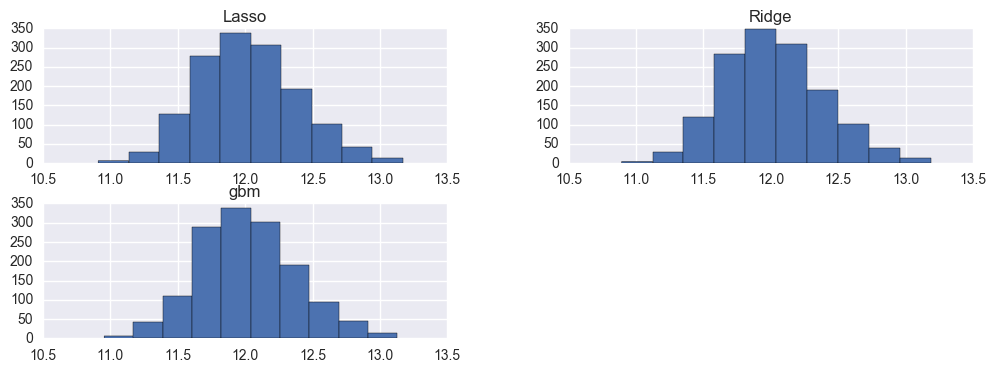

In [164]:
train_meta[['Lasso', 'Ridge', 'gbm']].hist()

In [165]:
train_meta[['Lasso', 'Ridge', 'gbm']].describe()

Lasso        Ridge          gbm
count  1434.000000  1434.000000  1434.000000
mean     12.019431    12.019164    12.019466
std       0.365701     0.366766     0.360238
min      10.909403    10.893542    10.953914
25%      11.765545    11.765883    11.775309
50%      11.996000    11.993578    11.997336
75%      12.258499    12.255577    12.247242
max      13.171028    13.184923    13.127577

In [167]:
ridge.alpha_, lasso.alpha_

(9.8971364010676535, 0.00019589140442649889)

### STEP 3:
#### Fit each base model to the full training dataset and make predictions on the test dataset. Store these predictions inside test_meta

In [168]:
ridge.fit(train_meta[features], output)
lasso.fit(train_meta[features], output)
gbm.fit(train_meta[features], output)
test_meta.loc[:,'Ridge'] = ridge.predict(test_meta[features])
test_meta.loc[:,'Lasso'] = lasso.predict(test_meta[features])
test_meta.loc[:,'gbm'] = gbm.predict(test_meta[features])

In [169]:
test_meta[['Lasso', 'Ridge', 'gbm']].describe()

Lasso        Ridge          gbm
count  1459.000000  1459.000000  1459.000000
mean     12.014882    12.015117    12.011306
std       0.393605     0.396323     0.387435
min      10.894208    10.913000    10.923821
25%      11.753049    11.751810    11.756805
50%      11.966100    11.965677    11.963779
75%      12.257044    12.255005    12.246262
max      13.726442    13.729060    13.289886

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120b041d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124658fd0>]], dtype=object)

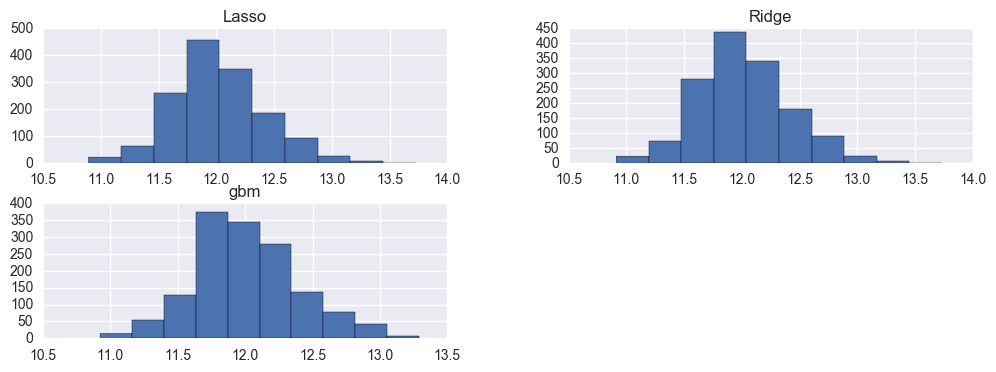

In [170]:
test_meta[['Lasso', 'Ridge', 'gbm']].hist()

### STEP 4:
#### Fit a new model, S (i.e the stacking model) to train_meta, using M1 and M2 as features. Optionally, include other features from the original training dataset or engineered features

In [171]:
train_meta.head(5)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.110874  9.183894            5            7       1924          1950   
1     3.091042  7.427144            6            5       1972          1972   
2     4.110874  8.881975            5            7       1920          1996   
3     4.290459  9.379830            9            5       2003          2004   
4     4.394449  9.467847            6            6       1972          1972   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.000000    5.973810         0.0   5.973810     6.665684  6.856462   
1    5.697093    0.000000         0.0   6.182085     6.182085  6.182085   
2    0.000000    0.000000         0.0   6.274762     6.274762  6.366470   
3    6.333280    7.357556         0.0   5.420535     7.491645  7.491645   
4    0.000000    6.386879         0.0   4.875197     6.584791  6.601230   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  5.609472           0.0   7.108244           1.0      0.000000         1   
1  6.224558           0.0   6.895683           0.0      0.000000         1   
2  6.274762           0.0   7.013915           0.0      0.000000         1   
3  0.000000           0.0   7.491645           1.0      0.000000         2   
4  6.493754           0.0   7.241366           0.0      0.693147         1   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         0             4      0.693147             7           0         1.0   
1         1             2      0.693147             5           1         1.0   
2         0             3      0.693147             6           0         1.0   
3         0             2      0.693147             6           1         3.0   
4         1             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       392.0    0.000000     0.000000       5.468060        0.0          0.0   
1       288.0    0.000000     0.000000       0.000000        0.0          0.0   
2       288.0    0.000000     0.000000       4.976734        0.0          0.0   
3       874.0    5.332719     3.912023       0.000000        0.0          0.0   
4       497.0    5.686975     4.762174       0.000000        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       3    2006               0.0               0.0   
1       0.0       6    2006               0.0               0.0   
2       0.0       3    2007               0.0               0.0   
3       0.0       8    2006               0.0               0.0   
4       0.0      12    2009               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              0              0   
2               0.0               0.0              0              0   
3               0.0               0.0              1              0   
4               0.0               0.0              0              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              1              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              1              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              1              0              0              0               0   

In [172]:
train_meta.drop('fold_ID', axis=1, inplace=True)

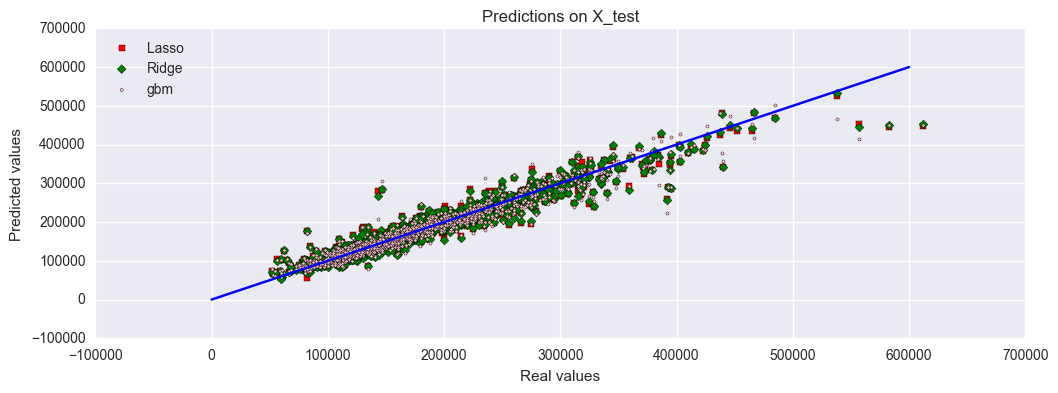

In [174]:
plt.scatter(np.expm1(output.values), np.expm1(train_meta['Lasso']), c = "red", marker = "s", label = "Lasso")
plt.scatter(np.expm1(output.values), np.expm1(train_meta['Ridge']), c = "green", marker = "D", label = "Ridge")
plt.scatter(np.expm1(output.values), np.expm1(train_meta['gbm']), c = "pink", marker = ".", label = "gbm")
plt.plot([0,600000],[0,600000], c="blue" )
plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

In [175]:
features = ['Lasso', 'Ridge', 'gbm']
#features = [x for x in train_meta.columns]
features

['Lasso', 'Ridge', 'gbm']

### Lets use xgboost to fit Stacked Model

In [176]:
def modelfit(model, dtrain, features, output, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[features].values, label=output.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the modelorithm on the data
    model.fit(dtrain[features], output, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
        
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print "Optimal CV Score:" 
    print(cvresult.iloc[len(cvresult)-1,:])
    print "Optimal iteration: %d" %(len(cvresult)-1)
    #print "Cross Validation Result: "
    #print(cvresult)
    
    plt.figure()
    cvresult.loc[:,["test-rmse-mean", "train-rmse-mean"]].plot()
    
    plt.figure()
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)[0:30] #gets feature_importances ...
    feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
    plt.ylabel('Feature Importance Score')
    return (len(cvresult))

In [178]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor


Model Report
R-Square: 0.951
RMSE : 0.084
Optimal CV Score:
test-rmse-mean     0.105605
test-rmse-std      0.005796
train-rmse-mean    0.081867
train-rmse-std     0.001013
Name: 7644, dtype: float64
Optimal iteration: 7644


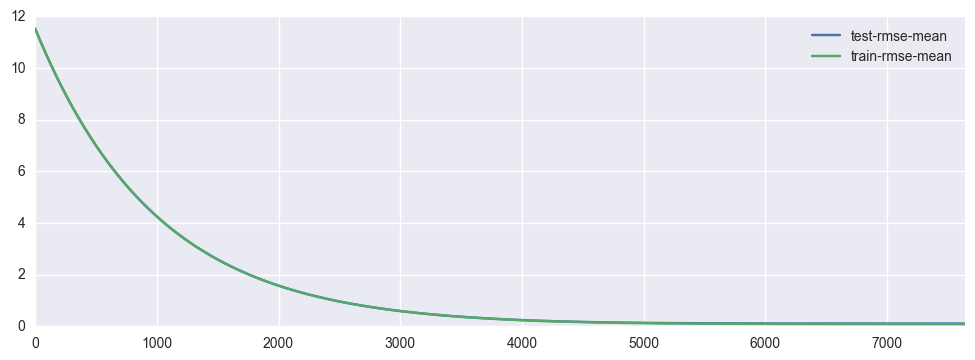

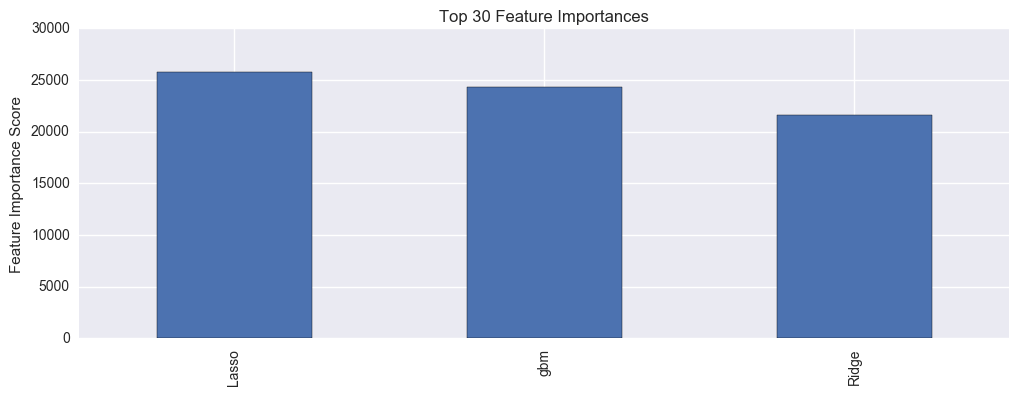

In [179]:
xgb1 = XGBRegressor(
 learning_rate =0.001,
 n_estimators=10000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
n_estimators = modelfit(xgb1, train_meta, features, output)

In [181]:
pred = np.expm1(xgb1.predict(test_meta[features]))
pred = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
pred.head(5)

Id     SalePrice
0  1461  125169.18750
1  1462  157819.03125
2  1463  180009.93750
3  1464  204274.59375
4  1465  184603.46875

In [182]:
#pred.to_csv('kaggle_submission_stacking_xgb_Jan292017.csv', index=False)

### Lets use poly features ridge to fit the stacked model

In [190]:
features = ['Lasso', 'Ridge', 'gbm']
#features = [x for x in train_meta.columns]
features

['Lasso', 'Ridge', 'gbm']

In [191]:
cols2drop = train_meta.filter(regex='\*2').columns.values
train_meta.drop(cols2drop, axis=1, inplace=True)

In [193]:
for col in features:
    train_meta[str(col) + "**2"] = train_meta[col]**2
    test_meta[str(col) + "**2"] = test_meta[col]**2

In [194]:
train_meta.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.110874  9.183894            5            7       1924          1950   
1     3.091042  7.427144            6            5       1972          1972   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.000000     5.97381         0.0   5.973810     6.665684  6.856462   
1    5.697093     0.00000         0.0   6.182085     6.182085  6.182085   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  5.609472           0.0   7.108244           1.0           0.0         1   
1  6.224558           0.0   6.895683           0.0           0.0         1   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         0             4      0.693147             7           0         1.0   
1         1             2      0.693147             5           1         1.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       392.0         0.0          0.0        5.46806        0.0          0.0   
1       288.0         0.0          0.0        0.00000        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       3    2006               0.0               0.0   
1       0.0       6    2006               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              0              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              1              0              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               1               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            0            1   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              0              0                 1              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    1                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     0                     0                     1   
1   

In [210]:
alpha = 10**np.random.uniform(-2,1, size=200)

In [211]:
ridge = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)

In [212]:
features = train_meta.filter(regex='Lasso|^Ridge|gbm').columns.values

In [213]:
ridge.fit(train_meta[features], output)

RidgeCV(alphas=array([ 0.01472,  7.12636, ...,  9.98991,  0.01741]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [214]:
ridge.alpha_

0.1460519127523722

In [216]:
pred = np.expm1(ridge.predict(test_meta[features])[:,0])
pred = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
pred.head(5)

Id      SalePrice
0  1461  123047.296161
1  1462  158447.210165
2  1463  186206.461966
3  1464  198259.698669
4  1465  189664.348413

In [217]:
#pred.to_csv('kaggle_submission_stacking_ridge_Jan292017.csv', index=False)